# Exercise 3: Normalizing Flows and Invertible Neural Networks

---

## Overview

This notebook implements and evaluates RealNVP (Real-valued Non-Volume Preserving) networks for:
1. Two Moons dataset (unconditional and conditional)
2. Hexagonal Gaussian Mixture Model
3. Higher-dimensional datasets (Digits and MNIST)

---

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Utility Functions

In [2]:
def compute_mmd(x, y, kernel='rbf', sigma=1.0):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()


    
    def rbf_kernel(x, y, sigma):
        xx = np.sum(x**2, axis=1)[:, None]
        yy = np.sum(y**2, axis=1)[None, :]
        xy = x @ y.T
        distances = xx - 2*xy + yy
        return np.exp(-distances / (2 * sigma**2))
    
    if kernel == 'rbf':
        K_xx = rbf_kernel(x, x, sigma)
        K_yy = rbf_kernel(y, y, sigma)
        K_xy = rbf_kernel(x, y, sigma)
    else:  # linear kernel
        K_xx = x @ x.T
        K_yy = y @ y.T
        K_xy = x @ y.T
    n = len(x)
    m = len(y)
    mmd = (K_xx.sum() - np.trace(K_xx)) / (n * (n-1))
    mmd += (K_yy.sum() - np.trace(K_yy)) / (m * (m-1))
    mmd -= 2 * K_xy.sum() / (n * m)
    
    return mmd


def generate_hexagon_gmm(n_samples, radius=1.0, std=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    
    angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 spaced angles
    centers = radius * np.array([[np.cos(a), np.sin(a)] for a in angles])
    
    samples_per_center = n_samples // 6
    X = []
    y = []
    
    for i, center in enumerate(centers):
        # Generate samples from this Gaussian
        samples = np.random.randn(samples_per_center, 2) * std + center
        X.append(samples)
        y.append(np.ones(samples_per_center) * i)
    
    X = np.vstack(X)
    y = np.hstack(y).astype(int)
    
    # Shuffle
    indices = np.random.permutation(len(X))
    
    return X[indices], y[indices]


def plot_samples(X, y=None, title="Data Samples", figsize=(8, 8)):
    plt.figure(figsize=figsize)
    if y is not None:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.6, s=20)
        plt.colorbar(scatter)
    else:
        plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=20)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_code_distribution(codes, title="Code Space Distribution"):

    #Plot histograms and Q-Q plots to check if codes are standard normal.
    if isinstance(codes, torch.Tensor):
        codes = codes.detach().cpu().numpy()
    
    n_dims = min(codes.shape[1], 4)  # Plot at most 4 dimensions
    
    fig, axes = plt.subplots(2, n_dims, figsize=(4*n_dims, 8))
    
    for i in range(n_dims):
        # Histogram
        axes[0, i].hist(codes[:, i], bins=50, density=True, alpha=0.7, label='Data')
        x = np.linspace(-4, 4, 100)
        axes[0, i].plot(x, np.exp(-x**2/2)/np.sqrt(2*np.pi), 'r-', label='N(0,1)')
        axes[0, i].set_title(f'Dimension {i+1}')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Q-Q plot
        from scipy import stats
        stats.probplot(codes[:, i], dist="norm", plot=axes[1, i])
        axes[1, i].set_title(f'Q-Q Plot Dim {i+1}')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

---

# Task 1: Two Moons with an Invertible Neural Network

## 1.1 RealNVP Architecture

We implement a RealNVP network consisting of coupling blocks.

In [3]:
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, mask, condition_size=0):
       
        super().__init__()
        self.mask = mask
        
        # Network to compute translation parameter
        self.translation_net = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
        
        # Network to compute scaling parameter
        self.scaling_net = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
    
    def forward(self, x, condition=None):

        x_masked = x * self.mask
        
        if condition is not None:
            net_input = torch.cat([x_masked, condition], dim=1)
        else:
            net_input = x_masked
        
        t = self.translation_net(net_input)
        s_raw = self.scaling_net(net_input)
        s = torch.tanh(s_raw)  # Bound the scaling
        
        # Apply  only non-masked dimensions
        z = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        
        
        log_det = torch.sum((1 - self.mask) * s, dim=1)
        
        return z, log_det
    
    def inverse(self, z, condition=None):
       
        z_masked = z * self.mask

        if condition is not None:
            net_input = torch.cat([z_masked, condition], dim=1)
        else:
            net_input = z_masked
        t = self.translation_net(net_input)
        s_raw = self.scaling_net(net_input)
        s = torch.tanh(s_raw)
        
        # Apply inverse transformation
        x = z_masked + (1 - self.mask) * ((z - t) * torch.exp(-s))
 
        log_det = -torch.sum((1 - self.mask) * s, dim=1)
        
        return x, log_det


class RealNVP(nn.Module):

    def __init__(self, input_size, hidden_size, blocks, condition_size=0):
        super().__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        
        self.coupling_layers = nn.ModuleList()
        self.rotation_matrices = []
        
        for i in range(blocks):
            # Alternate masks
            mask = torch.zeros(input_size)
            mask[:input_size//2] = 1
            if i % 2 == 1:
                mask = 1 - mask
            
            self.coupling_layers.append(
                CouplingLayer(input_size, hidden_size, mask, condition_size)
            )
            
            # Random orthogonal matrix for rotation (except last layer)
            if i < blocks - 1:
                Q, _ = torch.linalg.qr(torch.randn(input_size, input_size))
                self.rotation_matrices.append(Q)
    
    def forward(self, x, condition=None):
      
        z = x
        log_det_sum = 0
        
        for i, layer in enumerate(self.coupling_layers):
            z, log_det = layer(z, condition)
            log_det_sum += log_det
            
            # Apply rotation
            if i < len(self.coupling_layers) - 1:
                z = z @ self.rotation_matrices[i].to(z.device)
        
        return z, log_det_sum
    
    def inverse(self, z, condition=None):
       
        x = z
        log_det_sum = 0
        

        for i in range(len(self.coupling_layers) - 1, -1, -1):
            # Inverse rotation
            if i < len(self.coupling_layers) - 1:
                x = x @ self.rotation_matrices[i].T.to(x.device)
            
            x, log_det = self.coupling_layers[i].inverse(x, condition)
            log_det_sum += log_det
        
        return x, log_det_sum
    
    def sample(self, num_samples, conditions=None):
        self.eval()
        with torch.no_grad():
            if conditions is None:
                z = torch.randn(num_samples, self.input_size).to(next(self.parameters()).device)
                samples, _ = self.inverse(z)
            else:

                # Sample for each condition
                if not isinstance(conditions, torch.Tensor):
                    conditions = torch.tensor(conditions, dtype=torch.float32)
                conditions = conditions.to(next(self.parameters()).device)
                
                num_conditions = conditions.shape[0]
                z = torch.randn(num_conditions * num_samples, self.input_size).to(conditions.device)
                
                # Repeat conditions for each sample
                cond_repeated = conditions.repeat_interleave(num_samples, dim=0)
                
                samples, _ = self.inverse(z, cond_repeated)
        
        return samples.cpu().numpy()



def test_invertibility(model, x, condition=None):
    
    model.eval()
    with torch.no_grad():
        z, _ = model.forward(x, condition)
        x_reconstructed, _ = model.inverse(z, condition)
        error = torch.max(torch.abs(x - x_reconstructed)).item()
        print(f"Maximum reconstruction error: {error:.2e}")
        return error < 1e-5  # Should be very small (numerical precision)



## 1.2 Training Function

In [4]:


def train_inn(model, X_train, X_test=None,epochs=100, batch_size=64, lr=0.001, condition=None, condition_test=None,verbose=True):
    model.train()
    model = model.to(device)
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    X_train = X_train.to(device)
    
    if condition is not None:
        if not isinstance(condition, torch.Tensor):
            condition = torch.tensor(condition, dtype=torch.float32)
        condition = condition.to(device)
        dataset = TensorDataset(X_train, condition)
    else:
        dataset = TensorDataset(X_train)
    
    
    if X_test is not None:
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.tensor(X_test, dtype=torch.float32)
        X_test = X_test.to(device)
        
        if condition_test is not None:
            if not isinstance(condition_test, torch.Tensor):
                condition_test = torch.tensor(condition_test, dtype=torch.float32)
            condition_test = condition_test.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []



    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in dataloader:
            if condition is not None:
                x_batch, cond_batch = batch
            else:
                x_batch = batch[0]
                cond_batch = None
            
            # Forward pass
            z, log_det = model.forward(x_batch, cond_batch)
    
            log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.shape[1] * np.log(2 * np.pi)
            log_px = log_pz + log_det
            loss = -torch.mean(log_px)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_train_loss)
        

        if X_test is not None:
            model.eval() 
            with torch.no_grad():
                
                z_test, log_det_test = model.forward(X_test, condition_test)
                log_pz_test = -0.5 * torch.sum(z_test**2, dim=1) - 0.5 * z_test.shape[1] * np.log(2 * np.pi)
                log_px_test = log_pz_test + log_det_test
                avg_test_loss = -torch.mean(log_px_test).item()
                test_losses.append(avg_test_loss)
        
        if verbose and (epoch + 1) % 10 == 0:
            msg = f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}"
            if X_test is not None:
                msg += f", Test Loss: {avg_test_loss:.4f}"
            print(msg)
    
    return train_losses, test_losses



## 1.3 Two Moons Experiment

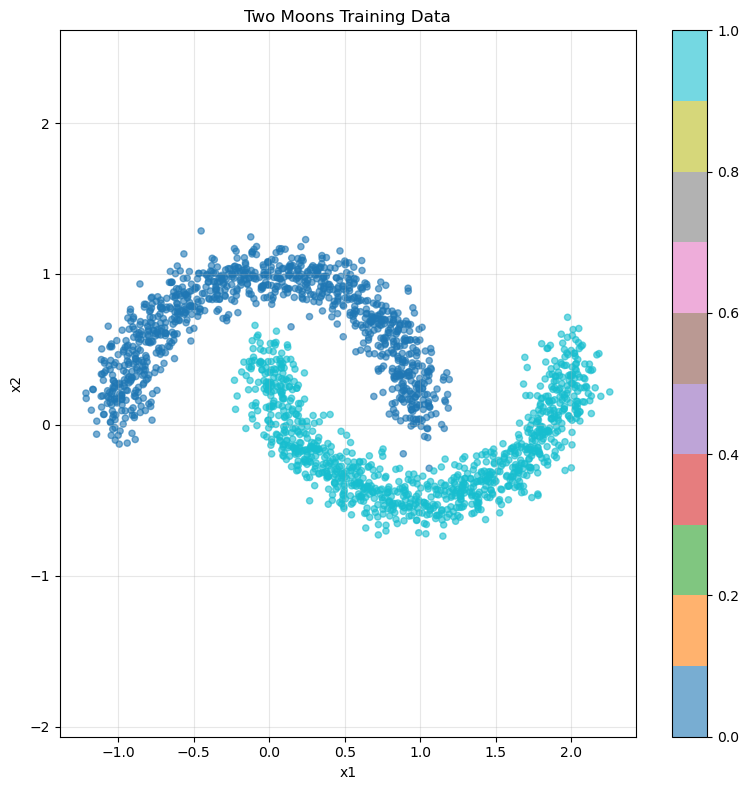

Training set: (2000, 2)
Test set: (1000, 2)


In [5]:

n_train = 2000
n_test = 1000
noise = 0.1

X_train, y_train = make_moons(n_samples=n_train, noise=noise, random_state=42)
X_test, y_test = make_moons(n_samples=n_test, noise=noise, random_state=43)
plot_samples(X_train, y_train, "Two Moons Training Data")

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

In [6]:
# Initialize and train RealNVP
#choose hyperparameters（）
input_size = 2
hidden_size = 64
blocks = 6

model_moons = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)


X_test_tensor = torch.tensor(X_test[:10], dtype=torch.float32).to(device)
model_moons = model_moons.to(device)
print("Testing invertibility:")
test_invertibility(model_moons, X_test_tensor)


losses_train, losses_test = train_inn(
    model_moons, 
    X_train, 
    X_test=X_test,   
    epochs=200, 
    batch_size=64, 
    lr=0.001
)

plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Testing invertibility:
Maximum reconstruction error: 4.77e-07
Epoch [10/200], Train Loss: 1.2160, Test Loss: 1.1911
Epoch [20/200], Train Loss: 1.1962, Test Loss: 1.2418


KeyboardInterrupt: 

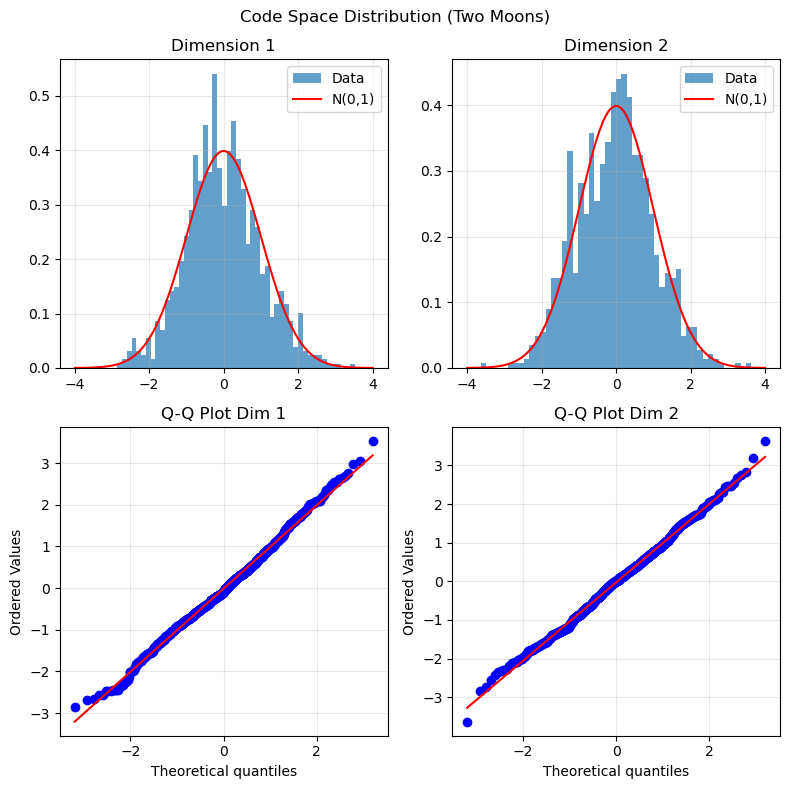

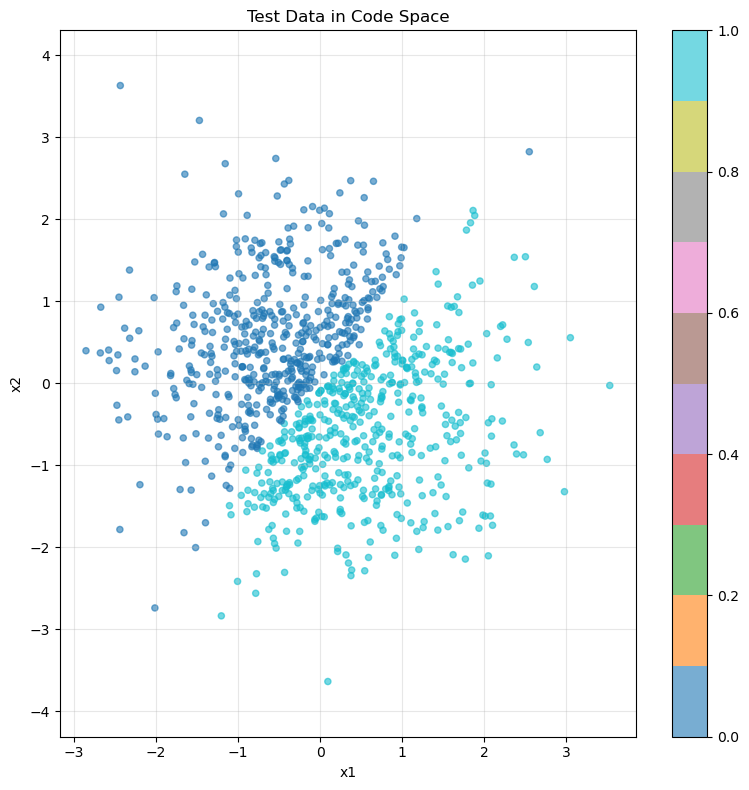

In [ ]:

model_moons.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    codes, _ = model_moons.forward(X_test_tensor)

plot_code_distribution(codes, "Code Space Distribution (Two Moons)")
plot_samples(codes.cpu().numpy(), y_test, "Test Data in Code Space")

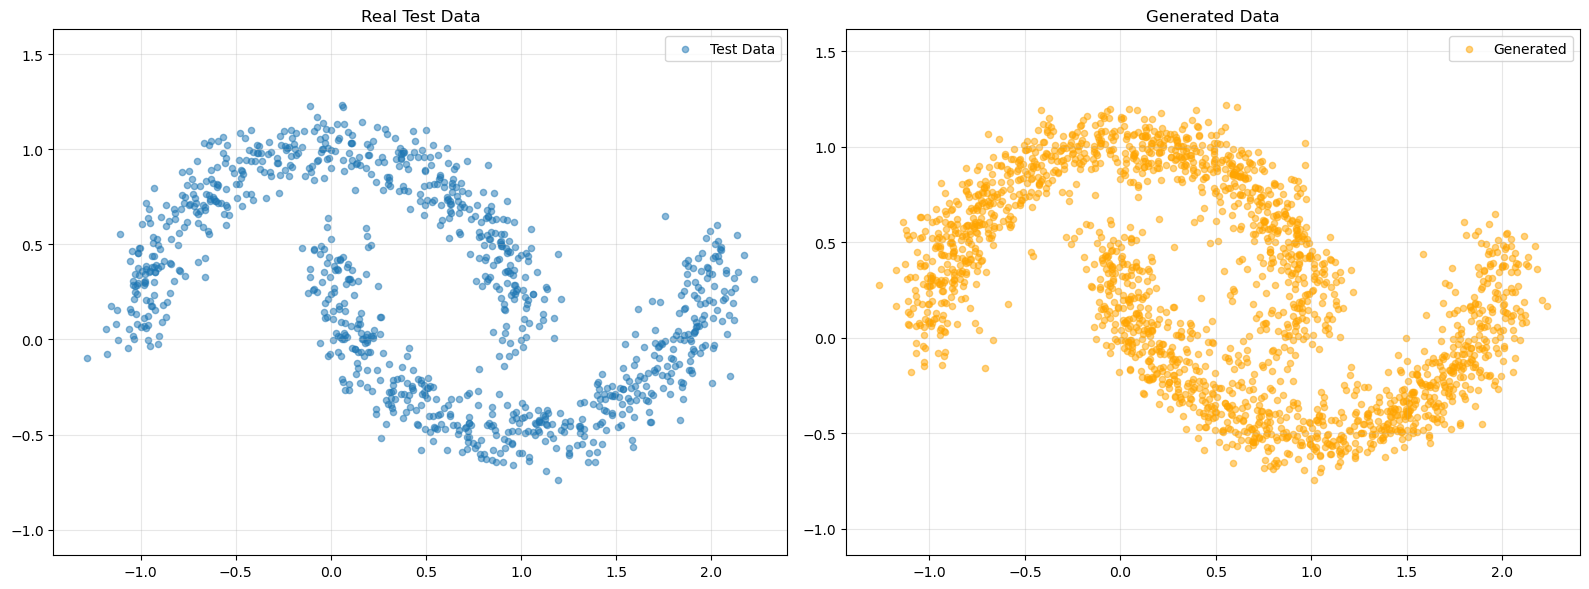


MMD between test and synthetic data: -0.000508


In [ ]:
# Generate synthetic samples
n_synthetic = 2000
X_synthetic = model_moons.sample(n_synthetic)



fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_test[:, 0], X_test[:, 1], alpha=0.5, s=20, label='Test Data')
axes[0].set_title('Real Test Data')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], alpha=0.5, s=20, label='Generated', color='orange')
axes[1].set_title('Generated Data')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

mmd = compute_mmd(X_test, X_synthetic, sigma=0.5)
print(f"\nMMD between test and synthetic data: {mmd:.6f}")

### Hyperparameter Study


=== Hyperparameter Study ===
Testing different configurations...


Training with 4 blocks...
Blocks: 4, MMD: -0.000382

Training with 6 blocks...
Blocks: 6, MMD: -0.000066

Training with 8 blocks...
Blocks: 8, MMD: 0.000035


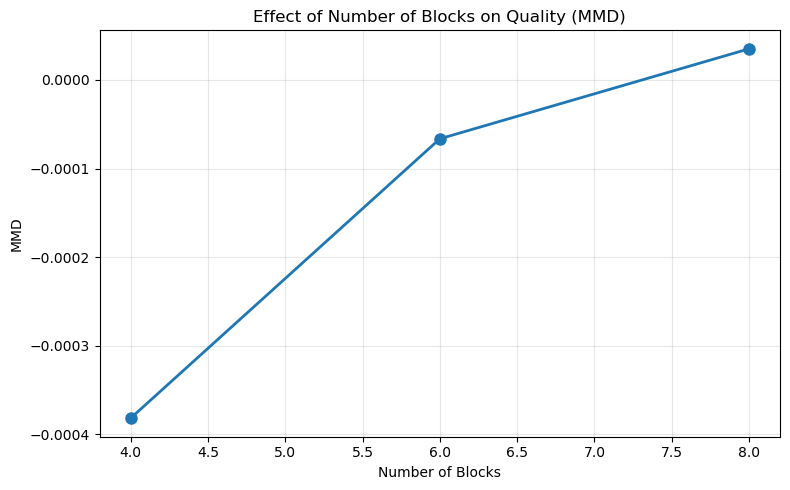


✓ Add more hyperparameter experiments as needed!


In [ ]:
print("\n=== Hyperparameter Study ===")
print("Testing different configurations...\n")

block_configs = [4, 6, 8]
mmd_results = []

for n_blocks in block_configs:
    print(f"\nTraining with {n_blocks} blocks...")
    model_temp = RealNVP(input_size=2, hidden_size=64, blocks=n_blocks)
    train_inn(model_temp, X_train, epochs=100, batch_size=64, lr=0.001, verbose=False)
    

    
    X_gen = model_temp.sample(1000)
    mmd = compute_mmd(X_test, X_gen, sigma=0.5)
    mmd_results.append(mmd)
    print(f"Blocks: {n_blocks}, MMD: {mmd:.6f}")

plt.figure(figsize=(8, 5))
plt.plot(block_configs, mmd_results, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Blocks')
plt.ylabel('MMD')
plt.title('Effect of Number of Blocks on Quality (MMD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Add more hyperparameter experiments as needed!")

## 1.4 Hexagonal GMM Experiment

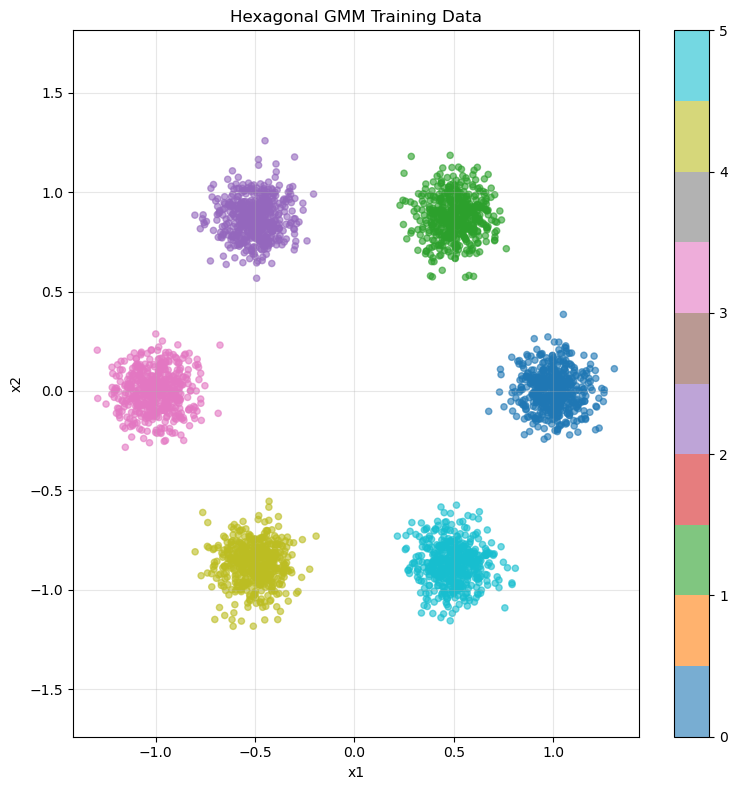

Training set: (3000, 2)
Test set: (996, 2)


In [ ]:
n_train_hex = 3000
n_test_hex = 1000
radius = 1.0
std_hex = radius / 10

X_train_hex, y_train_hex = generate_hexagon_gmm(n_train_hex, radius=radius, std=std_hex, seed=42)
X_test_hex, y_test_hex = generate_hexagon_gmm(n_test_hex, radius=radius, std=std_hex, seed=43)


plot_samples(X_train_hex, y_train_hex, "Hexagonal GMM Training Data")

print(f"Training set: {X_train_hex.shape}")
print(f"Test set: {X_test_hex.shape}")

Training RealNVP on Hexagonal GMM...
Epoch [10/200], Train Loss: 0.6629, Test Loss: 0.5926
Epoch [20/200], Train Loss: 0.5246, Test Loss: 0.5249
Epoch [30/200], Train Loss: 0.4580, Test Loss: 0.5032
Epoch [40/200], Train Loss: 1.1273, Test Loss: 0.6397
Epoch [50/200], Train Loss: 0.4005, Test Loss: 0.3623
Epoch [60/200], Train Loss: 0.3219, Test Loss: 0.3399
Epoch [70/200], Train Loss: 0.3555, Test Loss: 0.3816
Epoch [80/200], Train Loss: 0.3036, Test Loss: 0.3487
Epoch [90/200], Train Loss: 0.5607, Test Loss: 0.4895
Epoch [100/200], Train Loss: 0.4825, Test Loss: 0.4612
Epoch [110/200], Train Loss: 0.4220, Test Loss: 0.4174
Epoch [120/200], Train Loss: 0.6815, Test Loss: 0.4579
Epoch [130/200], Train Loss: 0.4152, Test Loss: 0.3882
Epoch [140/200], Train Loss: 0.3289, Test Loss: 0.2872
Epoch [150/200], Train Loss: 0.3361, Test Loss: 0.3414
Epoch [160/200], Train Loss: 0.2885, Test Loss: 0.3568
Epoch [170/200], Train Loss: 0.3314, Test Loss: 0.2728
Epoch [180/200], Train Loss: 0.2541, 

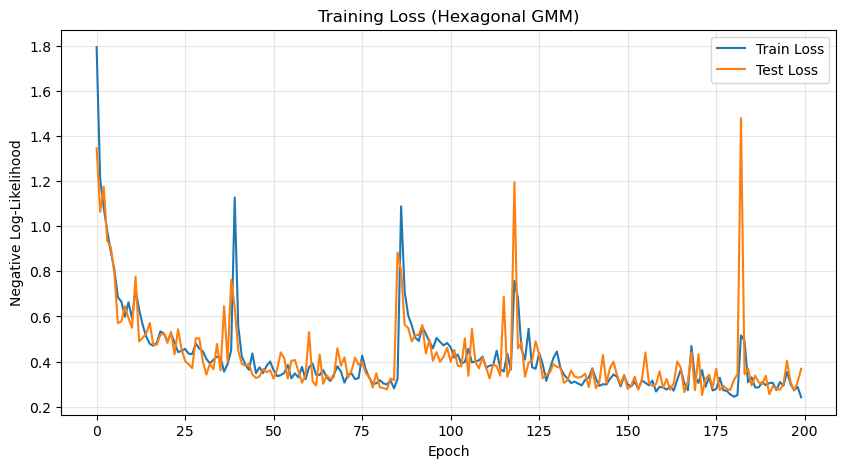

In [ ]:
# Train RealNVP on hexagonal GMM
model_hex = RealNVP(input_size=2, hidden_size=64, blocks=6)

print("Training RealNVP on Hexagonal GMM...")
losses_hex_train, losses_hex_test = train_inn(
    model_hex, 
    X_train_hex, 
    X_test=X_test_hex,
    epochs=200, 
    batch_size=64, 
    lr=0.001
)

plt.figure(figsize=(10, 5))
plt.plot(losses_hex_train, label='Train Loss')
plt.plot(losses_hex_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss (Hexagonal GMM)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

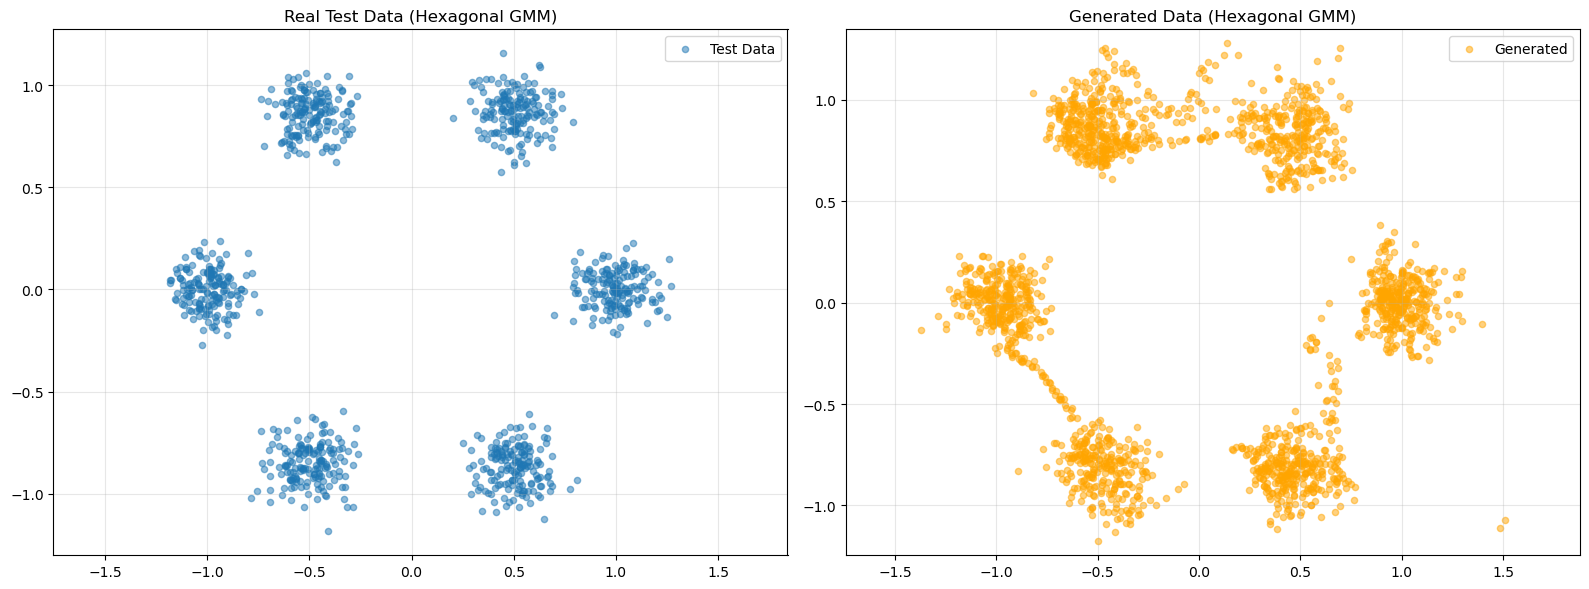


MMD between test and synthetic data: 0.002143

=== Observations ===


In [ ]:
# Generate and visualize synthetic samples
X_synthetic_hex = model_hex.sample(2000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(X_test_hex[:, 0], X_test_hex[:, 1], alpha=0.5, s=20, label='Test Data')
axes[0].set_title('Real Test Data (Hexagonal GMM)')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].scatter(X_synthetic_hex[:, 0], X_synthetic_hex[:, 1], alpha=0.5, s=20, label='Generated', color='orange')
axes[1].set_title('Generated Data (Hexagonal GMM)')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

mmd_hex = compute_mmd(X_test_hex, X_synthetic_hex, sigma=0.5)
print(f"\nMMD between test and synthetic data: {mmd_hex:.6f}")

print("\n=== Observations ===")

---

# Task 2: Two Moons with a Conditional Invertible Neural Network

Now we extend RealNVP to be conditional on labels.

## 2.1 Conditional Training - Two Moons

In [ ]:
# Prepare one-hot encoded labels for two moons
def one_hot_encode(labels, num_classes):
    n = len(labels)
    one_hot = np.zeros((n, num_classes))
    one_hot[np.arange(n), labels] = 1
    return one_hot

y_train_onehot = one_hot_encode(y_train, num_classes=2)
y_test_onehot = one_hot_encode(y_test, num_classes=2)

print(f"One-hot labels shape: {y_train_onehot.shape}")
print(f"First 5 labels: {y_train[:5]}")
print(f"First 5 one-hot:\n{y_train_onehot[:5]}")

One-hot labels shape: (2000, 2)
First 5 labels: [1 0 1 0 1]
First 5 one-hot:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


Training Conditional RealNVP on Two Moons...
Epoch [10/200], Train Loss: 0.4062, Test Loss: 0.3833
Epoch [20/200], Train Loss: 0.4020, Test Loss: 0.3724
Epoch [30/200], Train Loss: 0.3717, Test Loss: 0.3484
Epoch [40/200], Train Loss: 0.3466, Test Loss: 0.3807
Epoch [50/200], Train Loss: 0.3425, Test Loss: 0.3654
Epoch [60/200], Train Loss: 0.3441, Test Loss: 0.3627
Epoch [70/200], Train Loss: 0.3291, Test Loss: 0.3348
Epoch [80/200], Train Loss: 0.3405, Test Loss: 0.3314
Epoch [90/200], Train Loss: 0.3240, Test Loss: 0.3420
Epoch [100/200], Train Loss: 0.3456, Test Loss: 0.3330
Epoch [110/200], Train Loss: 0.3268, Test Loss: 0.3398
Epoch [120/200], Train Loss: 0.3303, Test Loss: 0.3291
Epoch [130/200], Train Loss: 0.3166, Test Loss: 0.3333
Epoch [140/200], Train Loss: 0.3404, Test Loss: 0.3288
Epoch [150/200], Train Loss: 0.3332, Test Loss: 0.3473
Epoch [160/200], Train Loss: 0.3096, Test Loss: 0.3609
Epoch [170/200], Train Loss: 0.3131, Test Loss: 0.3433
Epoch [180/200], Train Loss: 

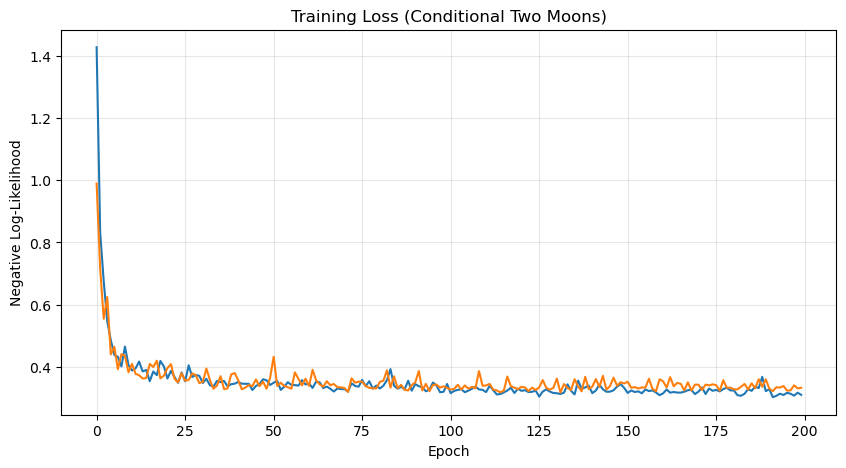

In [ ]:
model_cond_moons = RealNVP(input_size=2, hidden_size=64, blocks=6, condition_size=2)
print("Training Conditional RealNVP on Two Moons...")
losses_cond_train, losses_cond_test = train_inn(
    model_cond_moons, 
    X_train, 
    X_test=X_test,                  
    epochs=200, 
    batch_size=64, 
    lr=0.001, 
    condition=y_train_onehot,
    condition_test=y_test_onehot    
)


plt.figure(figsize=(10, 5))
plt.plot(losses_cond_train, label='Train Loss')
plt.plot(losses_cond_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss (Conditional Two Moons)')
plt.grid(True, alpha=0.3)
plt.show()

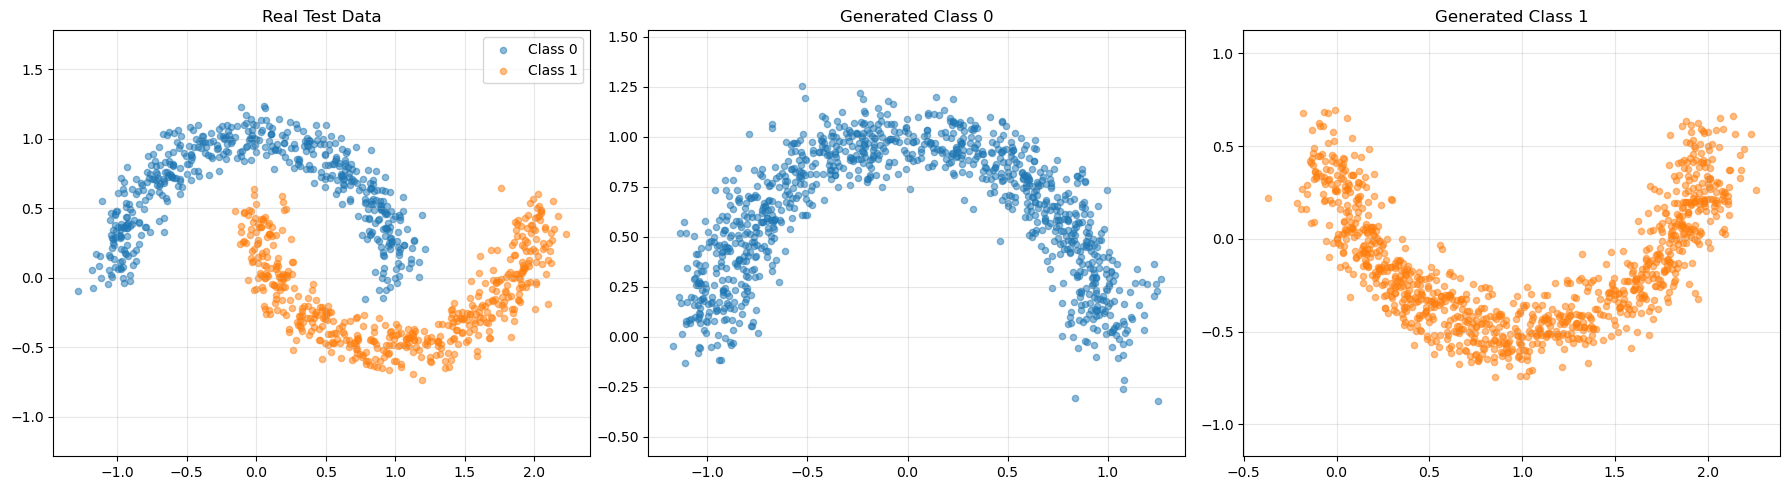


MMD for Class 0: -0.000920
MMD for Class 1: -0.000377


In [ ]:
n_samples_per_class = 1000

cond_0 = np.array([[1, 0]])
X_gen_0 = model_cond_moons.sample(n_samples_per_class, conditions=cond_0)

cond_1 = np.array([[0, 1]])
X_gen_1 = model_cond_moons.sample(n_samples_per_class, conditions=cond_1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5, label='Class 0', s=20)
axes[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], alpha=0.5, label='Class 1', s=20)
axes[0].set_title('Real Test Data')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_gen_0[:, 0], X_gen_0[:, 1], alpha=0.5, s=20, color='C0')
axes[1].set_title('Generated Class 0')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(X_gen_1[:, 0], X_gen_1[:, 1], alpha=0.5, s=20, color='C1')
axes[2].set_title('Generated Class 1')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


mmd_class_0 = compute_mmd(X_test[y_test==0], X_gen_0, sigma=0.5)
mmd_class_1 = compute_mmd(X_test[y_test==1], X_gen_1, sigma=0.5)
print(f"\nMMD for Class 0: {mmd_class_0:.6f}")
print(f"MMD for Class 1: {mmd_class_1:.6f}")

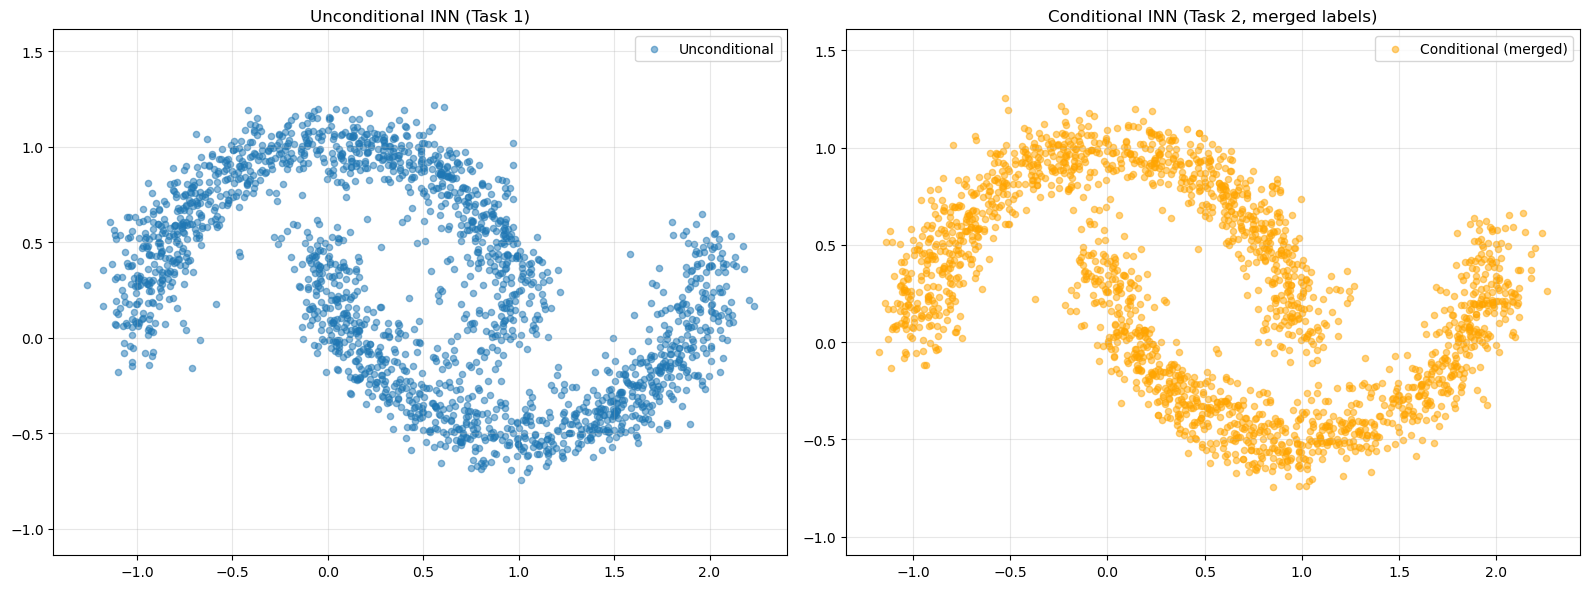


MMD (Unconditional): -0.000508
MMD (Conditional, merged): -0.000525

Observation: Is the conditional INN better or worse than the plain INN?


In [ ]:
# Compare marginal distribution with unconditional model
X_merged = np.vstack([X_gen_0, X_gen_1])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_synthetic[:, 0], X_synthetic[:, 1], alpha=0.5, s=20, label='Unconditional')
axes[0].set_title('Unconditional INN (Task 1)')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_merged[:, 0], X_merged[:, 1], alpha=0.5, s=20, label='Conditional (merged)', color='orange')
axes[1].set_title('Conditional INN (Task 2, merged labels)')
axes[1].legend()
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mmd_uncond = compute_mmd(X_test, X_synthetic, sigma=0.5)
mmd_cond_merged = compute_mmd(X_test, X_merged, sigma=0.5)

print(f"\nMMD (Unconditional): {mmd_uncond:.6f}")
print(f"MMD (Conditional, merged): {mmd_cond_merged:.6f}")
print("\nObservation: Is the conditional INN better or worse than the plain INN?")

## 2.2 Conditional Training - Hexagonal GMM (6 labels)

Training Conditional RealNVP on Hexagonal GMM (6 labels)...
Epoch [10/200], Train Loss: -1.7269, Test Loss: -1.7167
Epoch [20/200], Train Loss: -1.7446, Test Loss: -1.7328
Epoch [30/200], Train Loss: -1.7393, Test Loss: -1.7377
Epoch [40/200], Train Loss: -1.7477, Test Loss: -1.7423
Epoch [50/200], Train Loss: -1.7456, Test Loss: -1.7390
Epoch [60/200], Train Loss: -1.7540, Test Loss: -1.7770
Epoch [70/200], Train Loss: -1.7579, Test Loss: -1.7218
Epoch [80/200], Train Loss: -1.7564, Test Loss: -1.7604
Epoch [90/200], Train Loss: -1.7516, Test Loss: -1.7647
Epoch [100/200], Train Loss: -1.7476, Test Loss: -1.7440
Epoch [110/200], Train Loss: -1.7618, Test Loss: -1.7673
Epoch [120/200], Train Loss: -1.7604, Test Loss: -1.7561
Epoch [130/200], Train Loss: -1.7654, Test Loss: -1.7343
Epoch [140/200], Train Loss: -1.7585, Test Loss: -1.7564
Epoch [150/200], Train Loss: -1.7674, Test Loss: -1.7231
Epoch [160/200], Train Loss: -1.7639, Test Loss: -1.7658
Epoch [170/200], Train Loss: -1.7594,

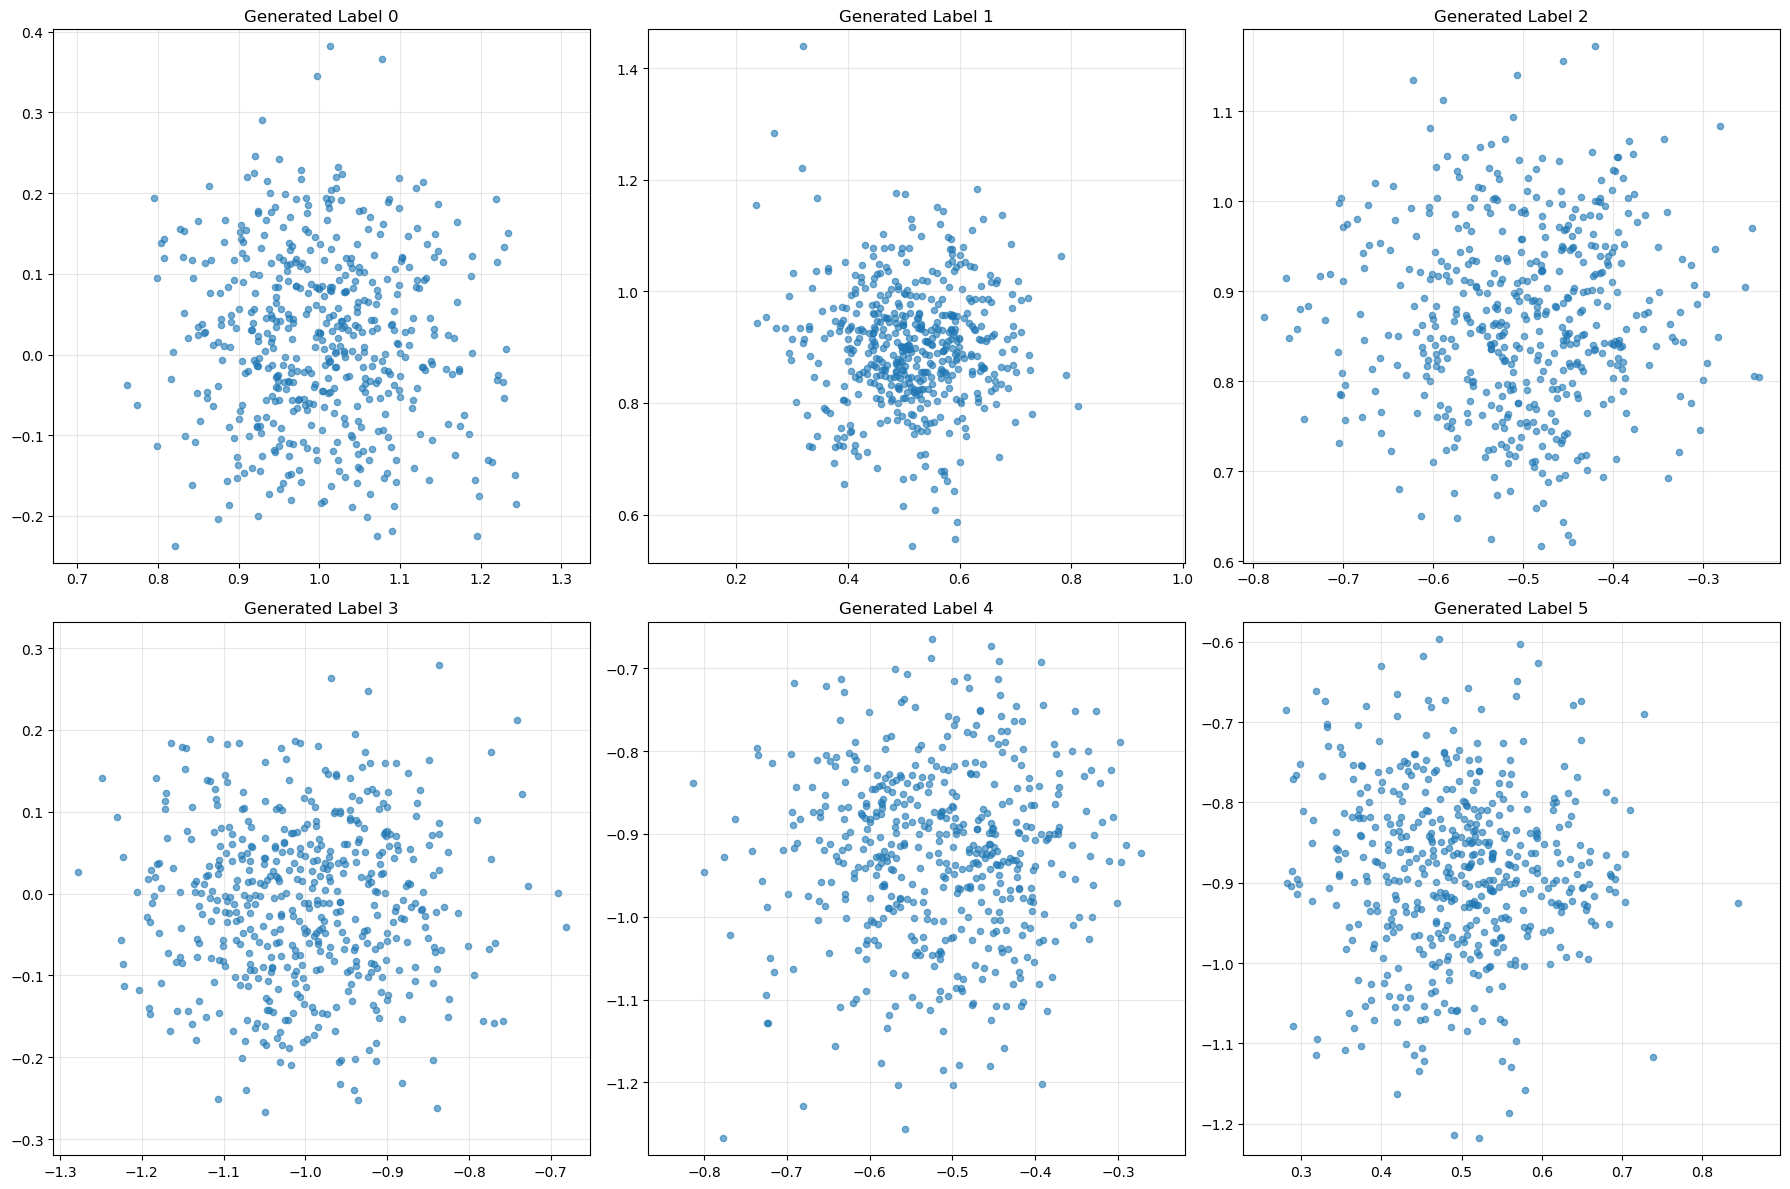

In [ ]:

y_train_hex_onehot = one_hot_encode(y_train_hex, num_classes=6)
y_test_hex_onehot = one_hot_encode(y_test_hex, num_classes=6)


model_cond_hex6 = RealNVP(input_size=2, hidden_size=64, blocks=6, condition_size=6)

print("Training Conditional RealNVP on Hexagonal GMM (6 labels)...")
losses_train, losses_test = train_inn(
    model_cond_hex6, 
    X_train_hex, 
    X_test=X_test_hex, 
    epochs=200, 
    batch_size=64, 
    lr=0.001, 
    condition=y_train_hex_onehot,
    condition_test=y_test_hex_onehot
)

# Generate samples for each label
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(6):
    cond = np.zeros((1, 6))
    cond[0, i] = 1
    X_gen = model_cond_hex6.sample(500, conditions=cond)
    
    axes[i].scatter(X_gen[:, 0], X_gen[:, 1], alpha=0.6, s=20)
    axes[i].set_title(f'Generated Label {i}')
    axes[i].axis('equal')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.3 Conditional Training - Hexagonal GMM (2 labels)

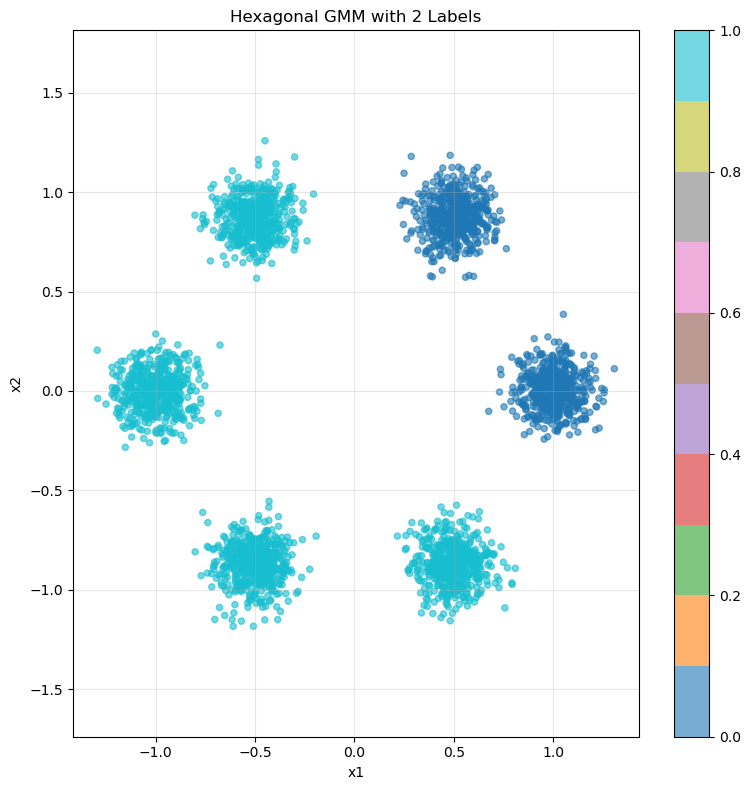

Training Conditional RealNVP on Hexagonal GMM (2 labels)...
Epoch [10/200], Train Loss: -0.2350, Test Loss: -0.2556
Epoch [20/200], Train Loss: -0.3303, Test Loss: -0.3351
Epoch [30/200], Train Loss: -0.3725, Test Loss: -0.4033
Epoch [40/200], Train Loss: -0.4364, Test Loss: -0.4353
Epoch [50/200], Train Loss: -0.3863, Test Loss: -0.4346
Epoch [60/200], Train Loss: -0.4687, Test Loss: -0.3691
Epoch [70/200], Train Loss: -0.4878, Test Loss: -0.3173
Epoch [80/200], Train Loss: -0.4846, Test Loss: -0.5023
Epoch [90/200], Train Loss: -0.4884, Test Loss: -0.4405
Epoch [100/200], Train Loss: -0.5054, Test Loss: -0.5050
Epoch [110/200], Train Loss: -0.5121, Test Loss: -0.5308
Epoch [120/200], Train Loss: -0.4730, Test Loss: -0.4772
Epoch [130/200], Train Loss: -0.5294, Test Loss: -0.4968
Epoch [140/200], Train Loss: -0.5492, Test Loss: -0.5205
Epoch [150/200], Train Loss: -0.5170, Test Loss: -0.4731
Epoch [160/200], Train Loss: -0.5182, Test Loss: -0.5348
Epoch [170/200], Train Loss: -0.5411,

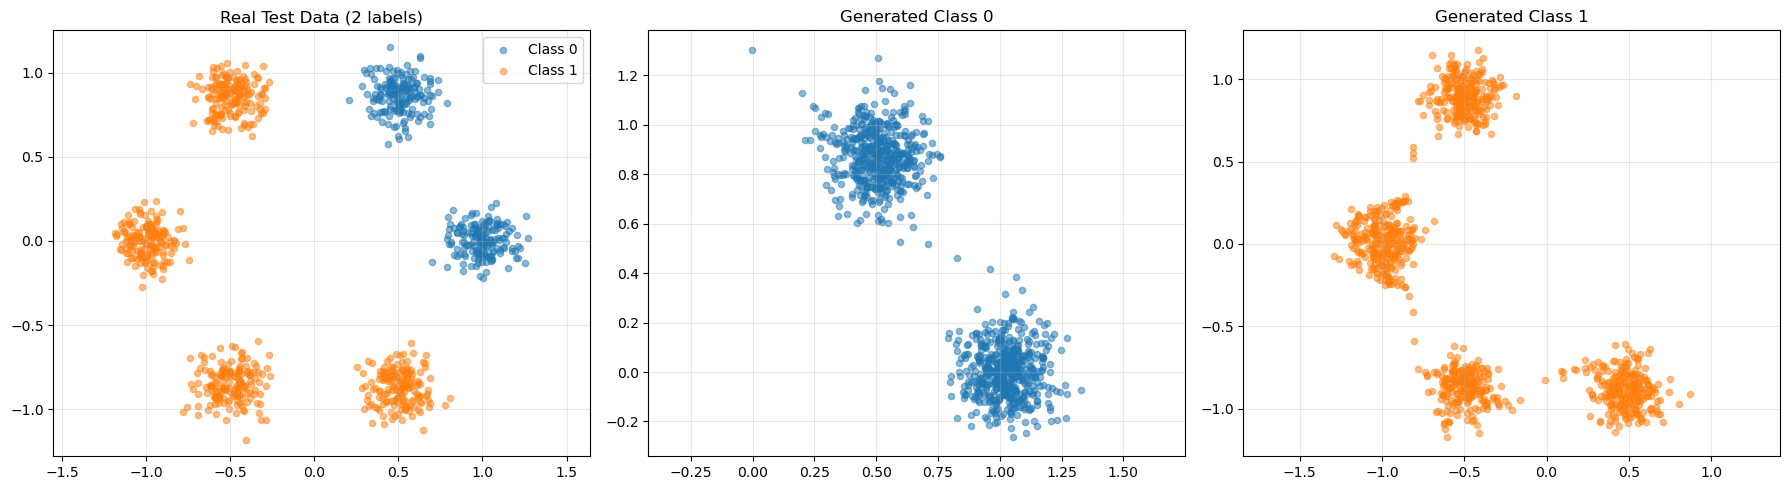

In [ ]:

def merge_labels(y):
    """Merge hexagon labels: 0,1 -> 0 and 2,3,4,5 -> 1."""
    y_merged = np.zeros_like(y)
    y_merged[y >= 2] = 1
    return y_merged

y_train_hex2 = merge_labels(y_train_hex)
y_test_hex2 = merge_labels(y_test_hex)

y_train_hex2_onehot = one_hot_encode(y_train_hex2, num_classes=2)
y_test_hex2_onehot = one_hot_encode(y_test_hex2, num_classes=2)


plot_samples(X_train_hex, y_train_hex2, "Hexagonal GMM with 2 Labels")

model_cond_hex2 = RealNVP(input_size=2, hidden_size=64, blocks=6, condition_size=2)
print("Training Conditional RealNVP on Hexagonal GMM (2 labels)...")
losses_train, losses_test = train_inn(
    model_cond_hex2, 
    X_train_hex, 
    X_test=X_test_hex, 
    epochs=200, 
    batch_size=64, 
    lr=0.001, 
    condition=y_train_hex2_onehot,
    condition_test=y_test_hex2_onehot
)

# Generate conditional samples
cond_0 = np.array([[1, 0]])
cond_1 = np.array([[0, 1]])

X_gen_hex2_0 = model_cond_hex2.sample(1000, conditions=cond_0)
X_gen_hex2_1 = model_cond_hex2.sample(1000, conditions=cond_1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_test_hex[y_test_hex2==0, 0], X_test_hex[y_test_hex2==0, 1], 
                alpha=0.5, label='Class 0', s=20)
axes[0].scatter(X_test_hex[y_test_hex2==1, 0], X_test_hex[y_test_hex2==1, 1], 
                alpha=0.5, label='Class 1', s=20)
axes[0].set_title('Real Test Data (2 labels)')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_gen_hex2_0[:, 0], X_gen_hex2_0[:, 1], alpha=0.5, s=20, color='C0')
axes[1].set_title('Generated Class 0')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(X_gen_hex2_1[:, 0], X_gen_hex2_1[:, 1], alpha=0.5, s=20, color='C1')
axes[2].set_title('Generated Class 1')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Task 3: Higher-Dimensional Data with an INN

## 3.1 Digits Dataset (sklearn)

Digits dataset shape: (1797, 64)
Labels shape: (1797,)
Number of classes: 10


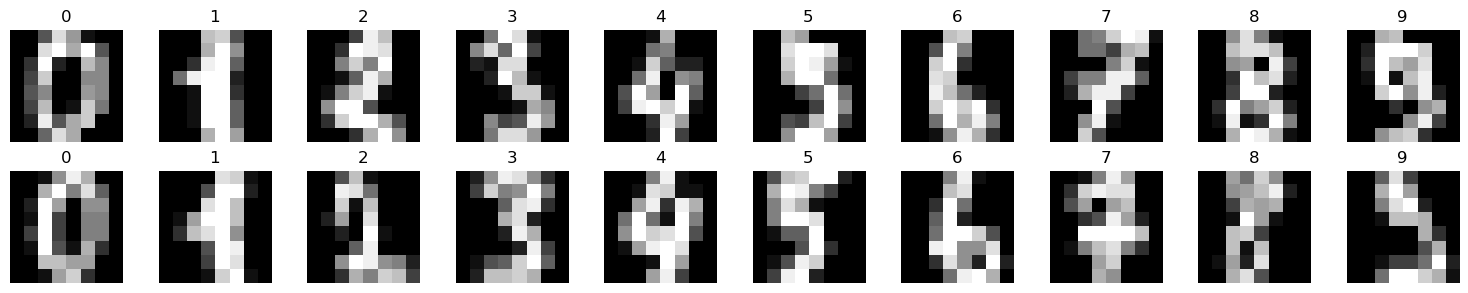


Training set: (1437, 64)
Test set: (360, 64)
Training RealNVP on Digits Dataset...


In [ ]:

digits = load_digits()
X_digits = digits.data / 16.0  # Normalize to [0, 1]
y_digits = digits.target

print(f"Digits dataset shape: {X_digits.shape}")
print(f"Labels shape: {y_digits.shape}")
print(f"Number of classes: {len(np.unique(y_digits))}")

# Visualize some digits
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(20):
    ax = axes[i // 10, i % 10]
    ax.imshow(X_digits[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'{y_digits[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


from sklearn.model_selection import train_test_split
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

print(f"\nTraining set: {X_train_digits.shape}")
print(f"Test set: {X_test_digits.shape}")

model_digits = RealNVP(input_size=64, hidden_size=128, blocks=8)

print("Training RealNVP on Digits Dataset...")

Training RealNVP on Digits Dataset...
Epoch [10/100], Train Loss: -69.6154, Test Loss: -61.9330
Epoch [20/100], Train Loss: -83.4189, Test Loss: -61.8579
Epoch [30/100], Train Loss: -89.8115, Test Loss: -62.5230
Epoch [40/100], Train Loss: -97.2880, Test Loss: -58.3754
Epoch [50/100], Train Loss: -99.8402, Test Loss: -53.9978
Epoch [60/100], Train Loss: -105.2796, Test Loss: -43.4790
Epoch [70/100], Train Loss: -107.5529, Test Loss: -37.9362
Epoch [80/100], Train Loss: -110.2485, Test Loss: -32.1118
Epoch [90/100], Train Loss: -112.5714, Test Loss: -26.2001
Epoch [100/100], Train Loss: -113.3601, Test Loss: -13.5583


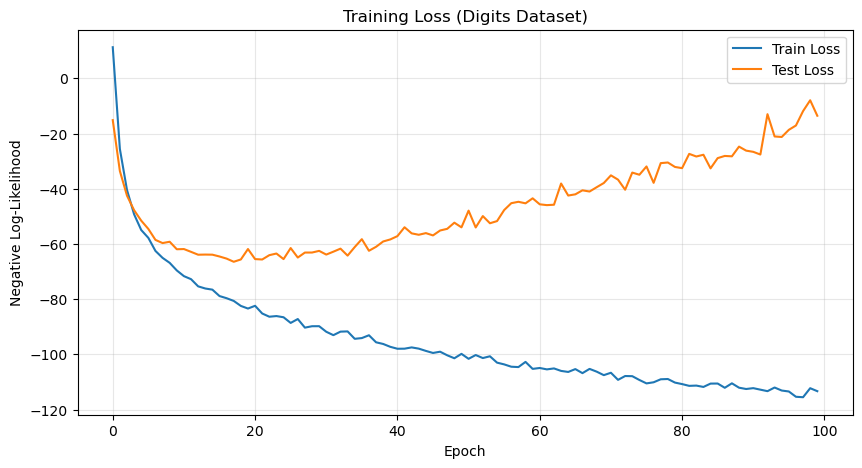

In [ ]:

model_digits = RealNVP(input_size=64, hidden_size=128, blocks=8)

print("Training RealNVP on Digits Dataset...")

losses_digits_train, losses_digits_test = train_inn(
    model_digits, 
    X_train_digits, 
    X_test=X_test_digits,
    epochs=100, 
    batch_size=32, 
    lr=0.001
)

plt.figure(figsize=(10, 5))
plt.plot(losses_digits_train, label='Train Loss')
plt.plot(losses_digits_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss (Digits Dataset)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

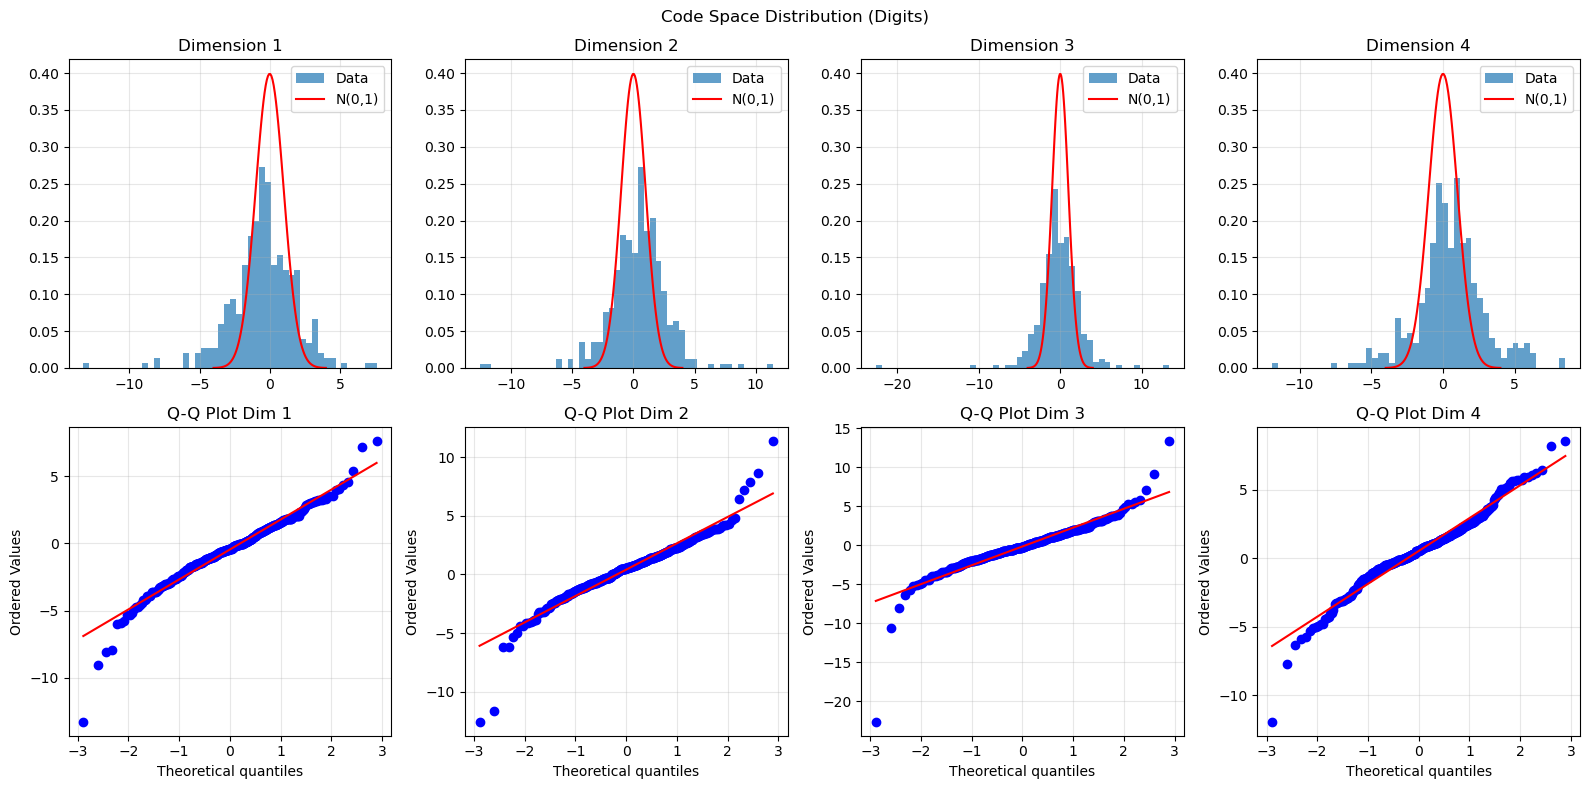

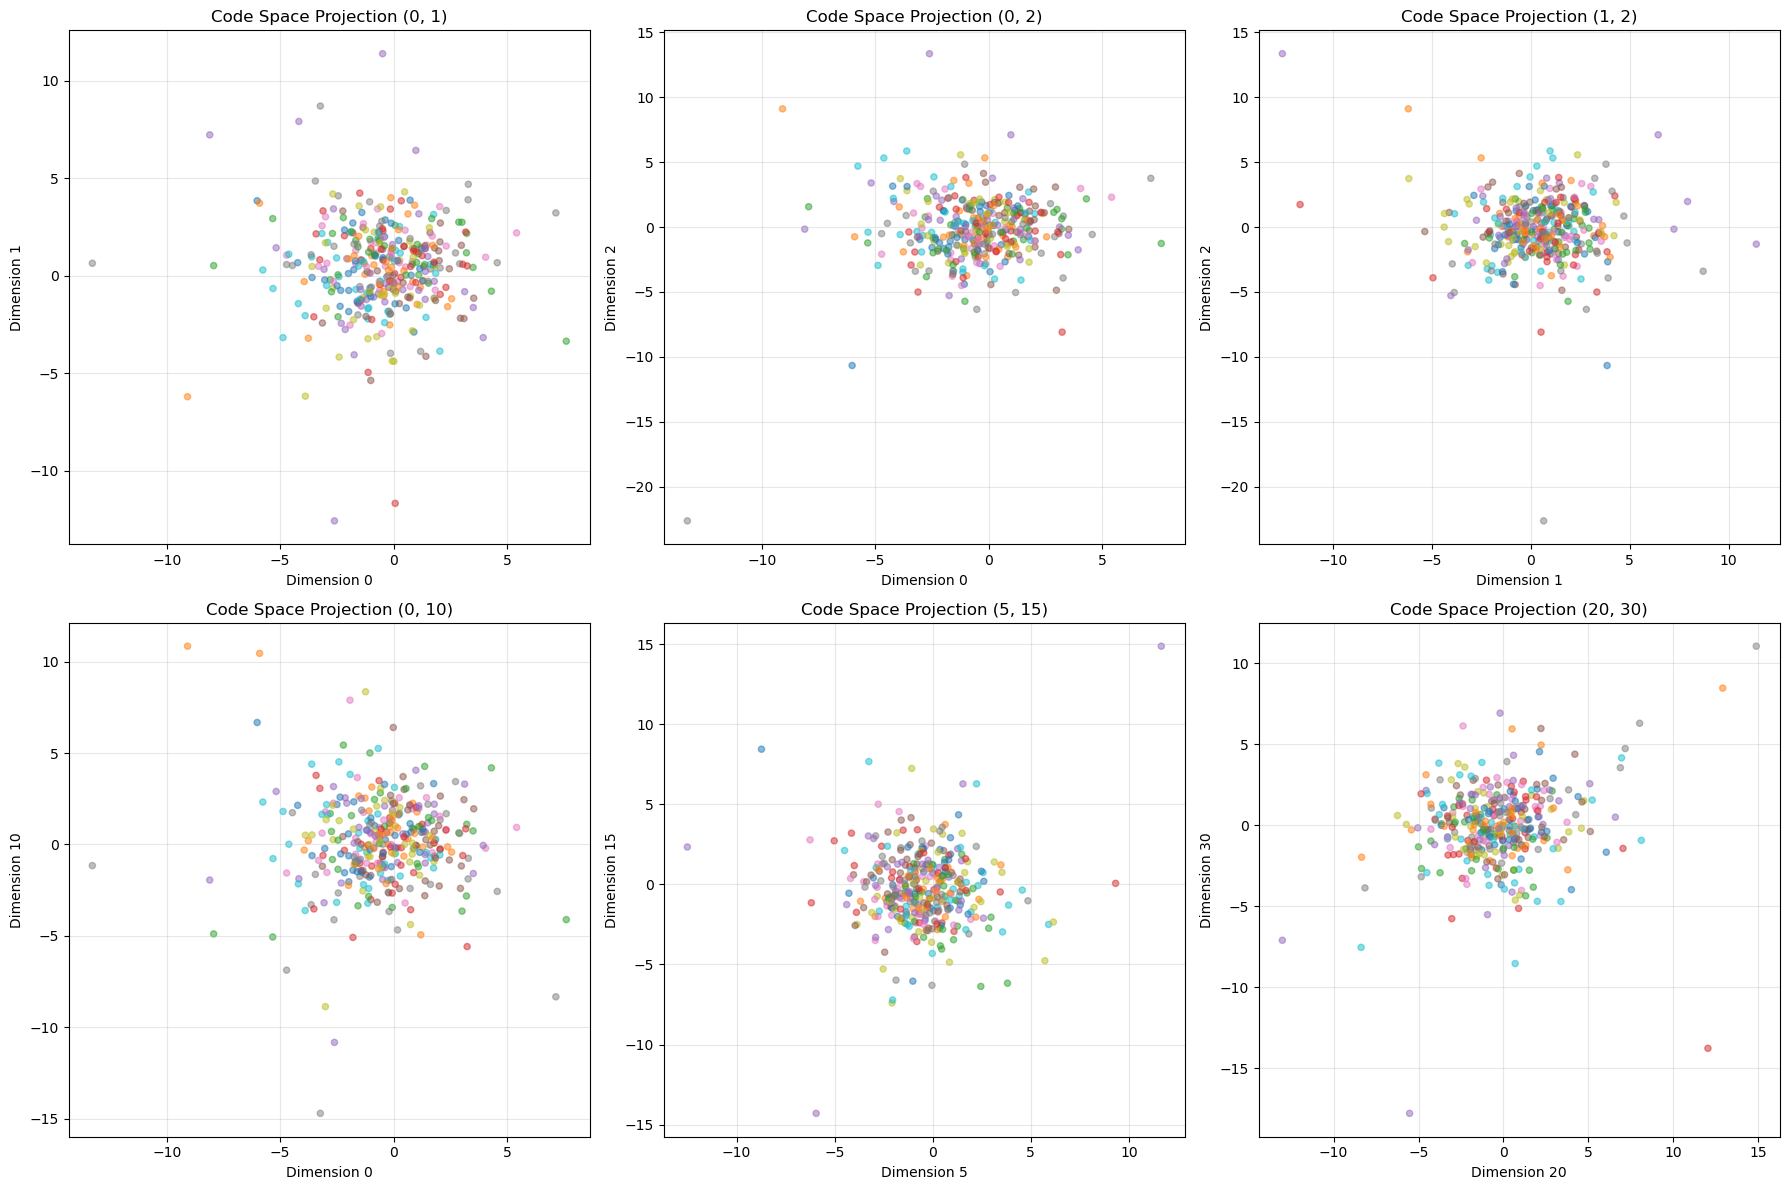

In [ ]:

model_digits.eval()
X_test_digits_tensor = torch.tensor(X_test_digits, dtype=torch.float32).to(device)
with torch.no_grad():
    codes_digits, _ = model_digits.forward(X_test_digits_tensor)

plot_code_distribution(codes_digits, "Code Space Distribution (Digits)")

# Plot various 2D projections
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

projections = [(0, 1), (0, 2), (1, 2), (0, 10), (5, 15), (20, 30)]
codes_np = codes_digits.cpu().numpy()

for idx, (i, j) in enumerate(projections):
    axes[idx].scatter(codes_np[:, i], codes_np[:, j], c=y_test_digits, 
                     cmap='tab10', alpha=0.5, s=20)
    axes[idx].set_xlabel(f'Dimension {i}')
    axes[idx].set_ylabel(f'Dimension {j}')
    axes[idx].set_title(f'Code Space Projection ({i}, {j})')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

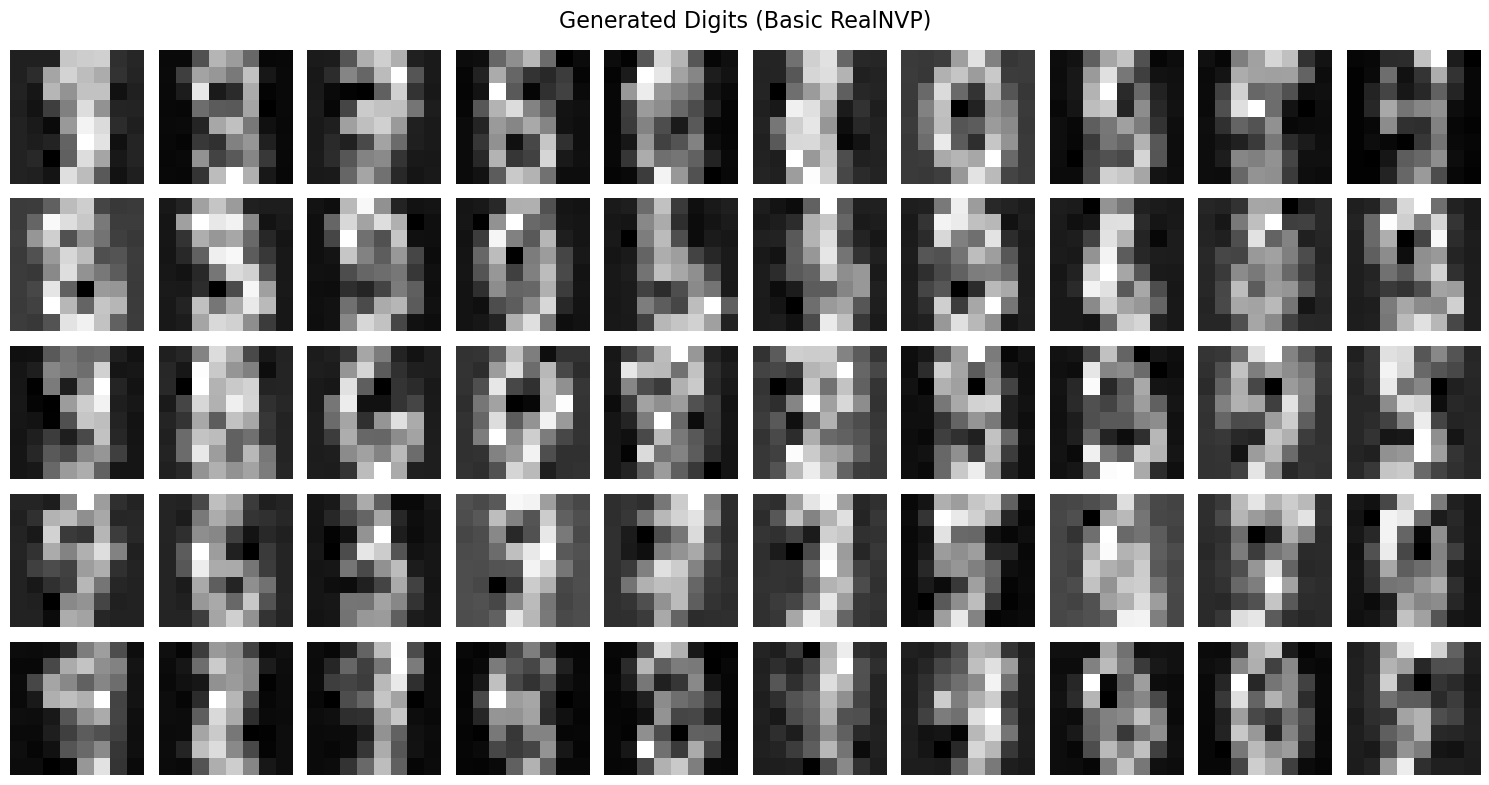


Observation: The quality may not be as good as autoencoders due to small dataset.


In [ ]:

X_synthetic_digits = model_digits.sample(100)

fig, axes = plt.subplots(5, 10, figsize=(15, 8))
axes = axes.flatten()

for i in range(50):
    axes[i].imshow(X_synthetic_digits[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')

plt.suptitle('Generated Digits (Basic RealNVP)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nObservation: The quality may not be as good as autoencoders due to small dataset.")

## 3.2 Bottleneck Method with Reconstruction Loss

In [ ]:
def train_inn_with_bottleneck(model, X_train, k_bottleneck, epochs=100, batch_size=32, 
                              lr=0.001, alpha_recon=1.0, condition=None, verbose=True):
    
    model.train()
    model = model.to(device)
    
    
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    X_train = X_train.to(device)
    
    if condition is not None:
        if not isinstance(condition, torch.Tensor):
            condition = torch.tensor(condition, dtype=torch.float32)
        condition = condition.to(device)
        dataset = TensorDataset(X_train, condition)
    else:
        dataset = TensorDataset(X_train)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses_nll = []
    losses_recon = []
    
    for epoch in range(epochs):
        epoch_loss_nll = 0
        epoch_loss_recon = 0
        
        for batch in dataloader:
            if condition is not None:
                x_batch, cond_batch = batch
            else:
                x_batch = batch[0]
                cond_batch = None
            
            # Forward pass for NLL
            z, log_det = model.forward(x_batch, cond_batch)
            
            # NLL loss (use all dimensions)
            log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.shape[1] * np.log(2 * np.pi)
            log_px = log_pz + log_det
            loss_nll = -torch.mean(log_px)
            
            # Reconstruction loss (use only first k dimensions)
            z_bottleneck = z.clone()
            z_bottleneck[:, k_bottleneck:] = 0  # Zero out unimportant dimensions
            x_recon, _ = model.inverse(z_bottleneck, cond_batch)
            loss_recon = torch.mean((x_batch - x_recon)**2)
            

            loss = loss_nll + alpha_recon * loss_recon
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss_nll += loss_nll.item()
            epoch_loss_recon += loss_recon.item()
        
        avg_nll = epoch_loss_nll / len(dataloader)
        avg_recon = epoch_loss_recon / len(dataloader)
        losses_nll.append(avg_nll)
        losses_recon.append(avg_recon)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], NLL: {avg_nll:.4f}, Recon: {avg_recon:.6f}")
    
    return losses_nll, losses_recon




Training RealNVP with Bottleneck (k=8)...

Epoch [10/100], NLL: -68.4581, Recon: 0.073532
Epoch [20/100], NLL: -82.6434, Recon: 0.073877
Epoch [30/100], NLL: -91.1739, Recon: 0.073743
Epoch [40/100], NLL: -95.9635, Recon: 0.074405
Epoch [50/100], NLL: -97.9559, Recon: 0.074424
Epoch [60/100], NLL: -102.8877, Recon: 0.074276
Epoch [70/100], NLL: -104.2312, Recon: 0.074318
Epoch [80/100], NLL: -108.2193, Recon: 0.074363
Epoch [90/100], NLL: -110.2226, Recon: 0.074611
Epoch [100/100], NLL: -113.0698, Recon: 0.074355


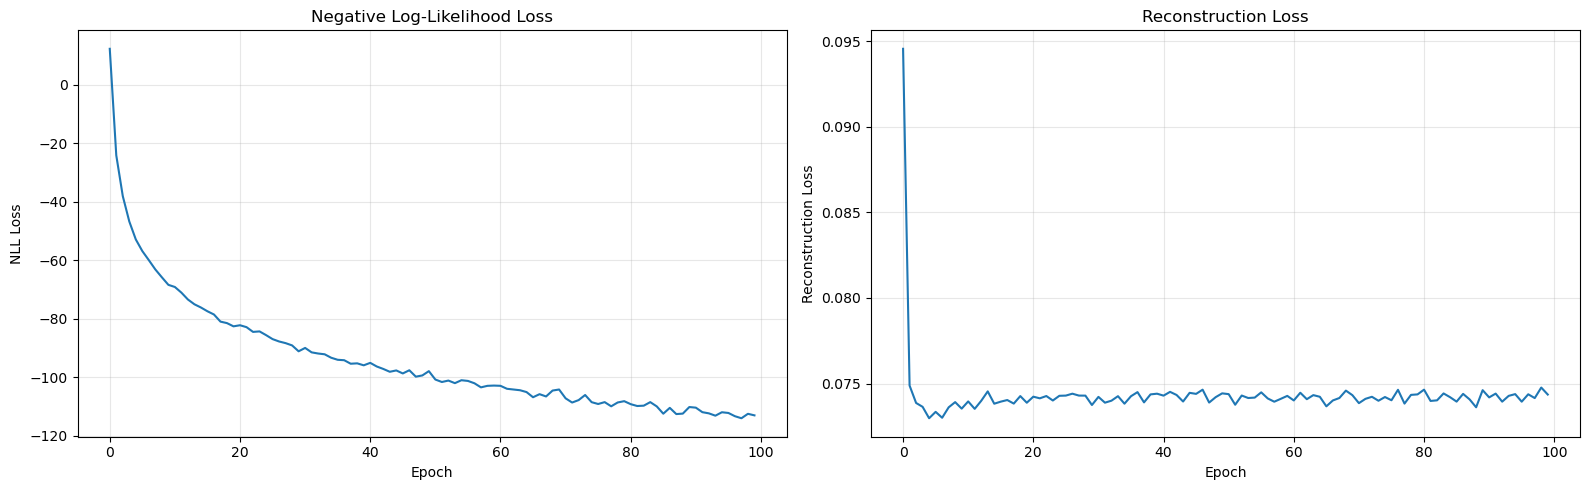

In [ ]:
# Train with bottleneck (k=8 or another value)
k_bottleneck = 8

model_digits_bottleneck = RealNVP(input_size=64, hidden_size=128, blocks=8)

print(f"Training RealNVP with Bottleneck (k={k_bottleneck})...\n")
losses_nll, losses_recon = train_inn_with_bottleneck(
    model_digits_bottleneck, X_train_digits, k_bottleneck=k_bottleneck,
    epochs=100, batch_size=32, lr=0.001, alpha_recon=10.0
)

# Plot losses
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(losses_nll)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('NLL Loss')
axes[0].set_title('Negative Log-Likelihood Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(losses_recon)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

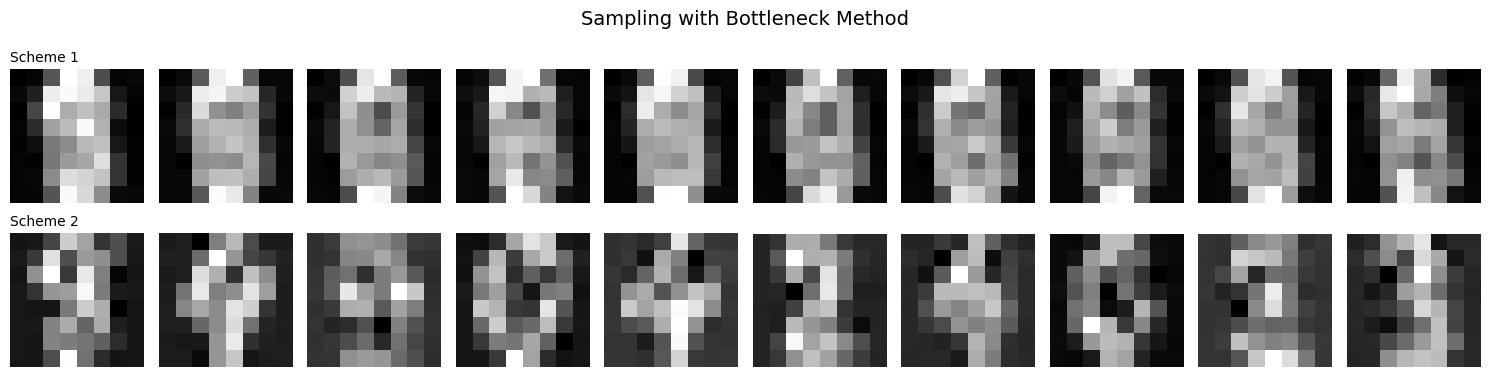


=== Observations ===
Scheme 1 (k dims only): Should look similar to autoencoder outputs
Scheme 2 (fixed k + sampled rest): Should add diversity while keeping general appearance


In [ ]:
# Sampling method 1: Sample only first k dimensions (rest are zero)
def sample_bottleneck_only(model, n_samples, k):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.input_size).to(device)
        z[:, k:] = 0  
        samples, _ = model.inverse(z)
    return samples.cpu().numpy()


# Sampling method 2: Fix first k dimensions, sample rest
def sample_diversity_mode(model, n_samples, k, fixed_z=None):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.input_size).to(device)
        
        if fixed_z is None:
            # Use mean of first k dimensions from training data
            fixed_z = torch.zeros(k).to(device)
        else:
            fixed_z = torch.tensor(fixed_z, dtype=torch.float32).to(device)
        
        z[:, :k] = fixed_z  # Fix important dimensions
        samples, _ = model.inverse(z)
    return samples.cpu().numpy()



n_gen = 50

X_gen_scheme1 = sample_bottleneck_only(model_digits_bottleneck, n_gen, k_bottleneck)
X_gen_scheme2 = sample_diversity_mode(model_digits_bottleneck, n_gen, k_bottleneck)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))




# Scheme 1: Only important dimensions
for i in range(10):
    axes[0, i].imshow(X_gen_scheme1[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
axes[0, 0].set_title('Scheme 1', loc='left', fontsize=10)

# Scheme 2: Fixed important + sampled unimportant
for i in range(10):
    axes[1, i].imshow(X_gen_scheme2[i].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
axes[1, 0].set_title('Scheme 2', loc='left', fontsize=10)

plt.suptitle('Sampling with Bottleneck Method', fontsize=14)
plt.tight_layout()
plt.show()

print("\n=== Observations ===")
print("Scheme 1 (k dims only): Should look similar to autoencoder outputs")
print("Scheme 2 (fixed k + sampled rest): Should add diversity while keeping general appearance")

## 3.3 MNIST Dataset (More Training Data)


MNIST training set: 60000 images
MNIST test set: 10000 images


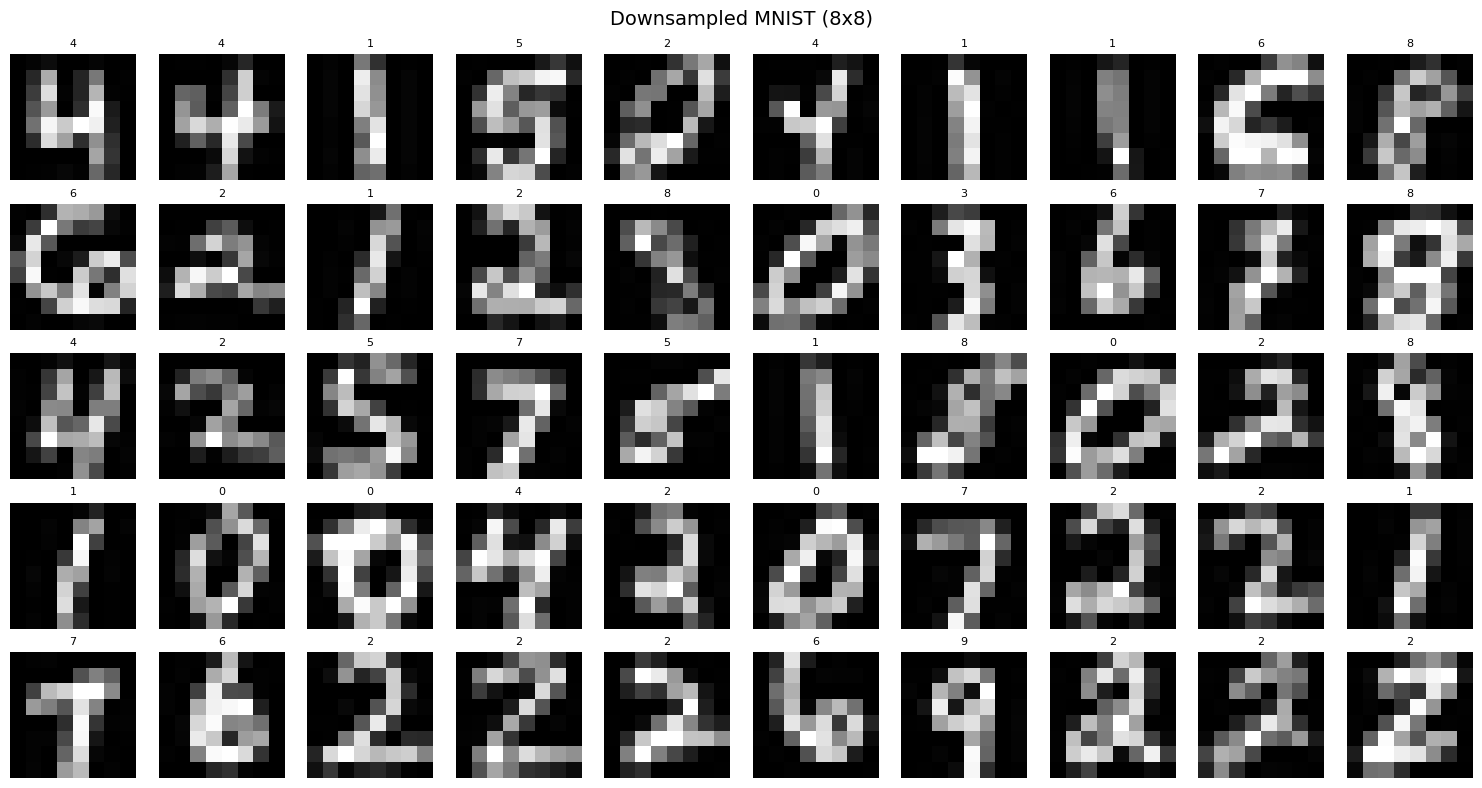

In [ ]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# Define downsampling transform
class DownsampleTransform:
    def __init__(self, target_shape, algorithm=Image.Resampling.LANCZOS):
        self.width, self.height = target_shape
        self.algorithm = algorithm
    
    def __call__(self, img):
        img = img.resize((self.width + 2, self.height + 2), self.algorithm)
        img = img.crop((1, 1, self.width + 1, self.height + 1))
        return img

# Setup transforms
transform = transforms.Compose([
    DownsampleTransform(target_shape=(8, 8)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])



print("Downloading MNIST dataset...")
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

mnist_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

print(f"\nMNIST training set: {len(mnist_dataset)} images")
print(f"MNIST test set: {len(mnist_test)} images")

# Visualize first batch
fig, axes = plt.subplots(5, 10, figsize=(15, 8))
axes = axes.flatten()

for batch in mnist_loader:
    x_batch, y_batch = batch
    for i in range(50):
        axes[i].imshow(x_batch[i].reshape(8, 8), cmap='gray')
        axes[i].set_title(f'{y_batch[i].item()}', fontsize=8)
        axes[i].axis('off')
    break

plt.suptitle('Downsampled MNIST (8x8)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Prepare MNIST data for training
X_mnist_train = []
y_mnist_train = []


X_mnist_test = []
y_mnist_test = []

print("Processing MNIST test data...")
for x_batch, y_batch in mnist_test_loader:

    X_mnist_test.append(x_batch.reshape(-1, 64).numpy())
    y_mnist_test.append(y_batch.numpy())

X_mnist_test = np.vstack(X_mnist_test)
y_mnist_test = np.hstack(y_mnist_test)

print(f"MNIST test data shape: {X_mnist_test.shape}")
print(f"MNIST test labels shape: {y_mnist_test.shape}")



for x_batch, y_batch in mnist_loader:
    X_mnist_train.append(x_batch.reshape(-1, 64).numpy())
    y_mnist_train.append(y_batch.numpy())

X_mnist_train = np.vstack(X_mnist_train)
y_mnist_train = np.hstack(y_mnist_train)

print(f"MNIST training data shape: {X_mnist_train.shape}")
print(f"MNIST labels shape: {y_mnist_train.shape}")

Processing MNIST test data...
MNIST test data shape: (10000, 64)
MNIST test labels shape: (10000,)
MNIST training data shape: (60000, 64)
MNIST labels shape: (60000,)


Training RealNVP on MNIST...
Epoch [10/50], Train Loss: -95.8887, Test Loss: -89.1659
Epoch [20/50], Train Loss: -109.7630, Test Loss: -98.0751
Epoch [30/50], Train Loss: -117.6043, Test Loss: -89.3431
Epoch [40/50], Train Loss: -122.7461, Test Loss: -90.1581
Epoch [50/50], Train Loss: -126.7673, Test Loss: -83.3639


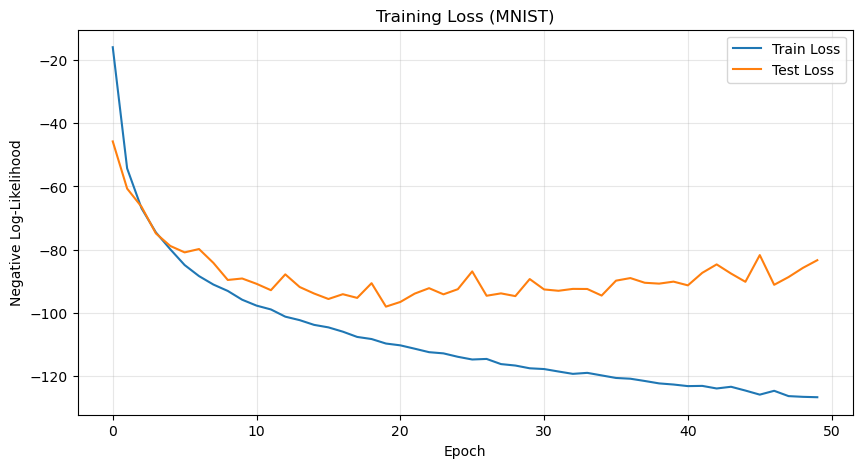

In [ ]:
model_mnist = RealNVP(input_size=64, hidden_size=256, blocks=10)

print("Training RealNVP on MNIST...")
subset_size = 10000
X_subset = X_mnist_train[:subset_size]


losses_mnist_train, losses_mnist_test = train_inn(
    model_mnist, 
    X_subset,        
    X_test=X_mnist_test, 
    epochs=50, 
    batch_size=128, 
    lr=0.001
)

plt.figure(figsize=(10, 5))
plt.plot(losses_mnist_train, label='Train Loss')
plt.plot(losses_mnist_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss (MNIST)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

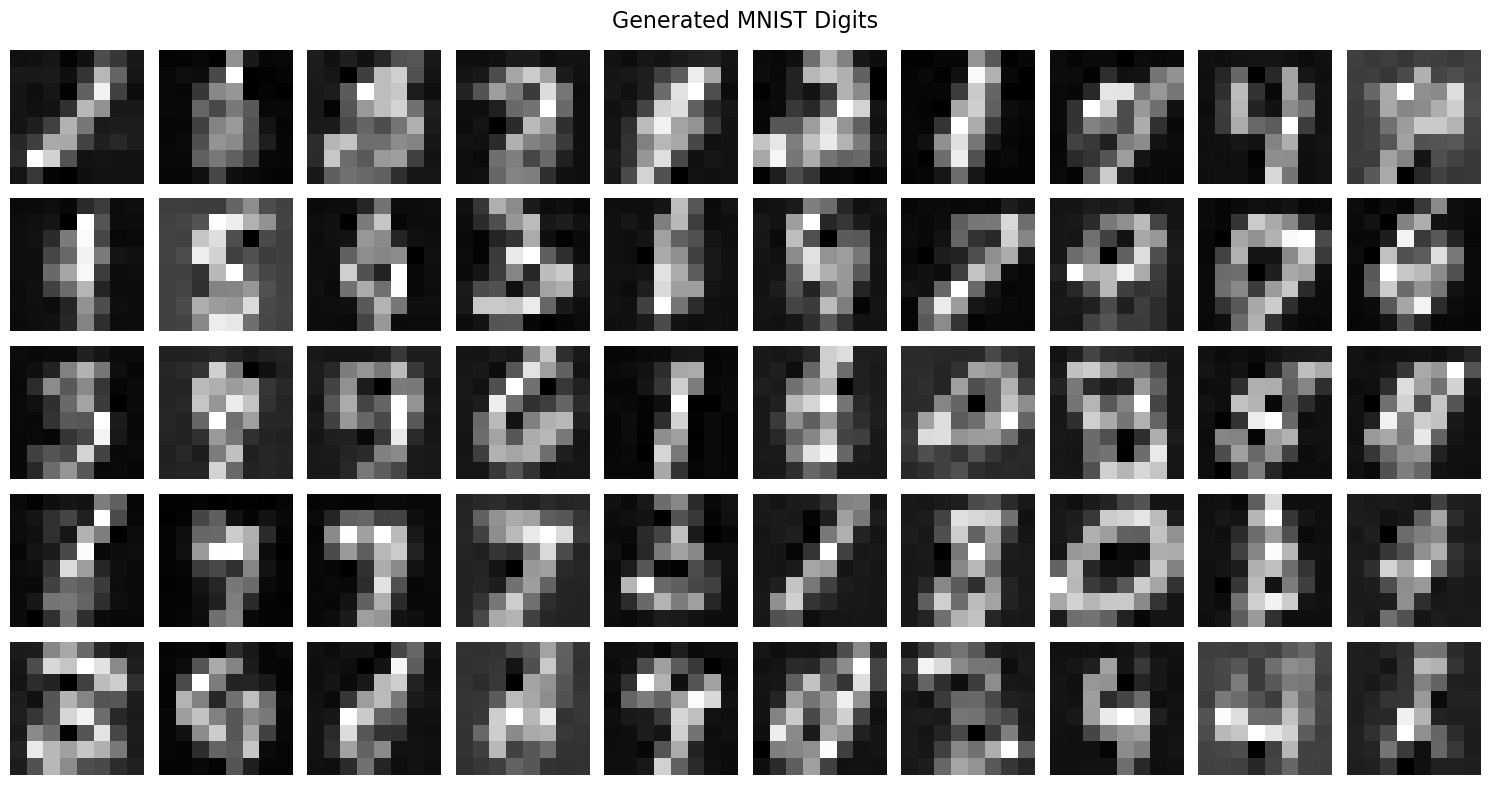


With more training data, the quality improved compared to sklearn digits.


In [ ]:
X_gen_mnist = model_mnist.sample(100)


fig, axes = plt.subplots(5, 10, figsize=(15, 8))
axes = axes.flatten()

for i in range(50):
    axes[i].imshow(X_gen_mnist[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')

plt.suptitle('Generated MNIST Digits', fontsize=16)
plt.tight_layout()
plt.show()

print("\nWith more training data, the quality improved compared to sklearn digits.")

---

# Task 4: Higher-Dimensional Data with a Conditional INN

Train conditional RealNVP using digit labels.

## 4.1 Conditional RealNVP on Digits

In [ ]:

y_train_digits_onehot = one_hot_encode(y_train_digits, num_classes=10)
y_test_digits_onehot = one_hot_encode(y_test_digits, num_classes=10)
print(f"One-hot labels shape: {y_train_digits_onehot.shape}")

One-hot labels shape: (1437, 10)


Training Conditional RealNVP on Digits...

Epoch [10/100], Train Loss: -70.7041, Test Loss: -65.2966
Epoch [20/100], Train Loss: -86.3604, Test Loss: -70.4317
Epoch [30/100], Train Loss: -94.9120, Test Loss: -69.0267
Epoch [40/100], Train Loss: -101.2881, Test Loss: -62.3847
Epoch [50/100], Train Loss: -104.9585, Test Loss: -59.5955
Epoch [60/100], Train Loss: -109.7224, Test Loss: -52.3477
Epoch [70/100], Train Loss: -111.4487, Test Loss: -44.7028
Epoch [80/100], Train Loss: -114.7786, Test Loss: -38.9364
Epoch [90/100], Train Loss: -116.4842, Test Loss: -33.2886
Epoch [100/100], Train Loss: -118.4491, Test Loss: -24.5611


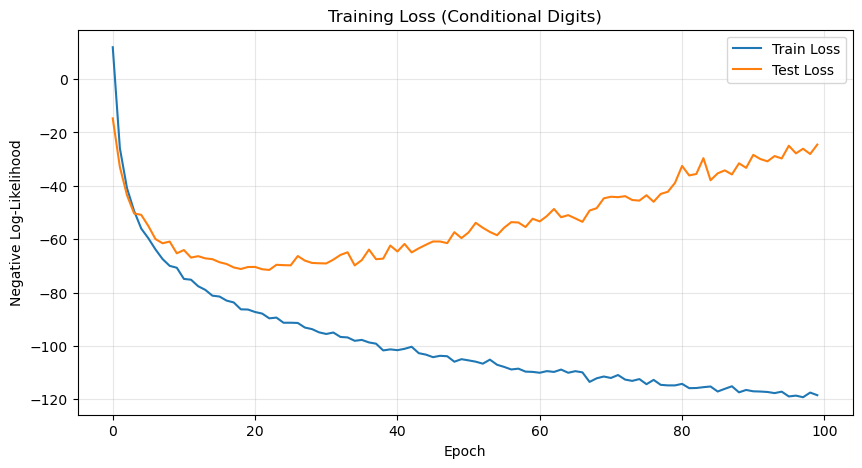

In [ ]:
model_cond_digits = RealNVP(input_size=64, hidden_size=128, blocks=8, condition_size=10)

print("Training Conditional RealNVP on Digits...\n")
losses_cond_digits_train, losses_cond_digits_test = train_inn(
    model_cond_digits, 
    X_train_digits, 
    X_test=X_test_digits,              
    epochs=100, 
    batch_size=32,
    lr=0.001, 
    condition=y_train_digits_onehot,
    condition_test=y_test_digits_onehot  
)


plt.figure(figsize=(10, 5))
plt.plot(losses_cond_digits_train, label='Train Loss')
plt.plot(losses_cond_digits_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss (Conditional Digits)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

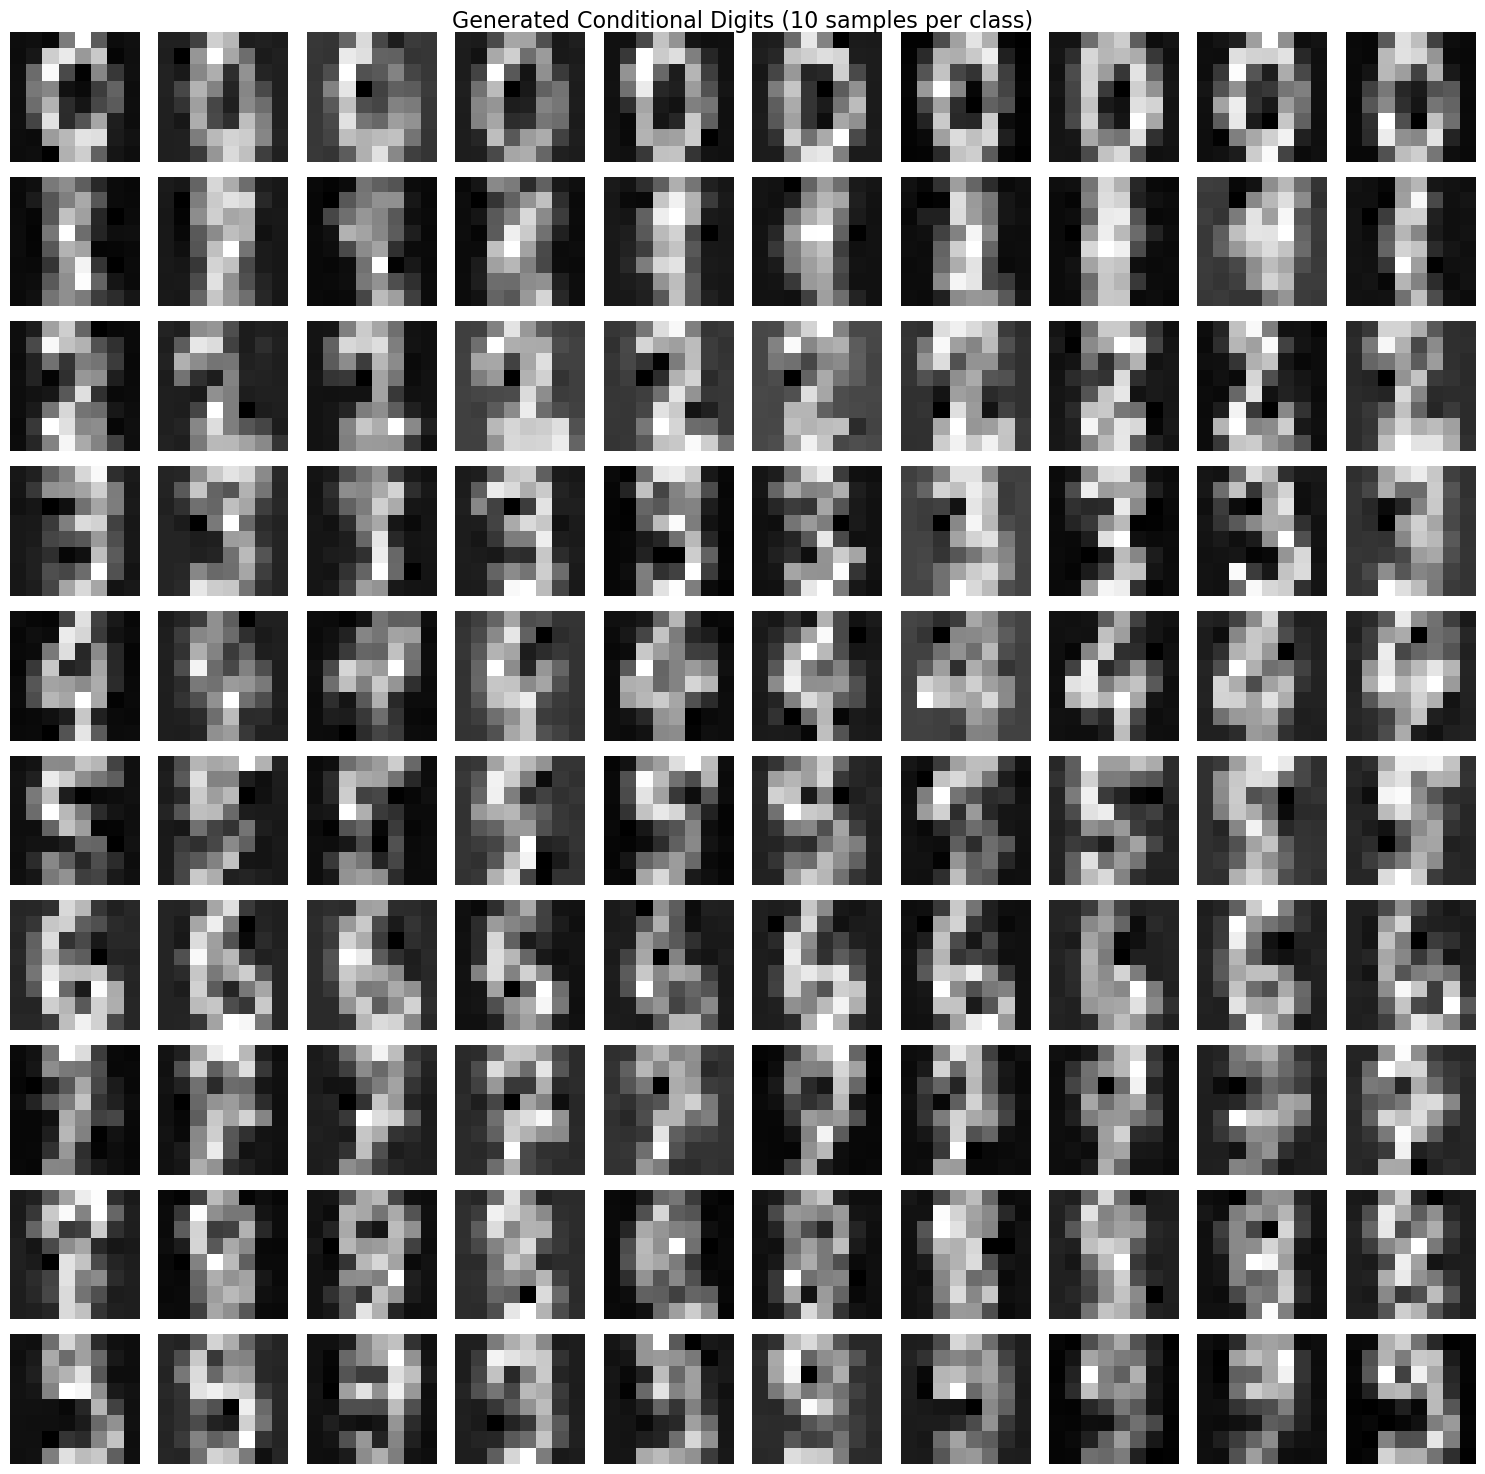


Observation: generated digits look likes the target digit


In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for digit in range(10):
    # Create condition for this digit
    cond = np.zeros((1, 10))
    cond[0, digit] = 1
    
    # Generate 10 samples
    X_gen = model_cond_digits.sample(10, conditions=cond)
    
    for i in range(10):
        axes[digit, i].imshow(X_gen[i].reshape(8, 8), cmap='gray')
        axes[digit, i].axis('off')
    
    axes[digit, 0].set_ylabel(f'Digit {digit}', fontsize=12)

plt.suptitle('Generated Conditional Digits (10 samples per class)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nObservation: generated digits look likes the target digit")

## 4.2 Evaluation with Random Forest Classifier

In [ ]:
# Generate synthetic dataset
n_synthetic_per_class = 100
X_synthetic_all = []
y_synthetic_all = []

for digit in range(10):
    cond = np.zeros((1, 10))
    cond[0, digit] = 1
    X_gen = model_cond_digits.sample(n_synthetic_per_class, conditions=cond)
    X_synthetic_all.append(X_gen)
    y_synthetic_all.append(np.ones(n_synthetic_per_class) * digit)

X_synthetic_all = np.vstack(X_synthetic_all)
y_synthetic_all = np.hstack(y_synthetic_all).astype(int)

print(f"Synthetic dataset shape: {X_synthetic_all.shape}")
print(f"Synthetic labels shape: {y_synthetic_all.shape}")

Synthetic dataset shape: (1000, 64)
Synthetic labels shape: (1000,)


Training Random Forest on real data...
Accuracy on real test data: 0.9611
Accuracy on synthetic data: 0.9170

Average confidence on synthetic data: 0.6168


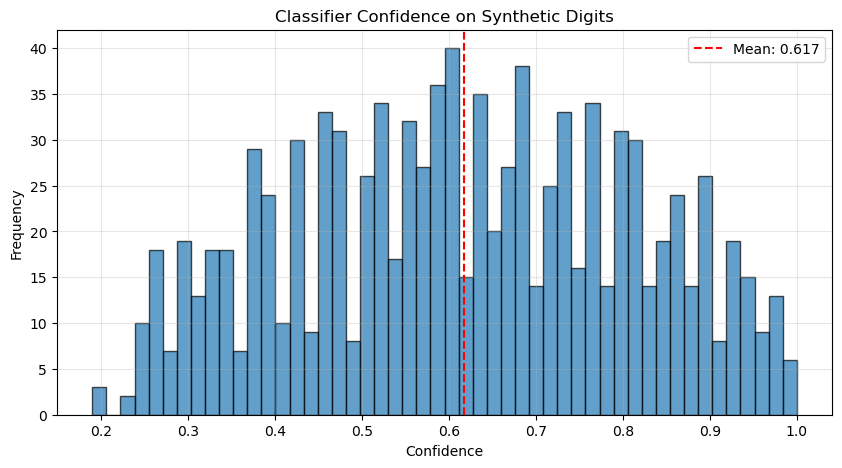


=== Summary ===
The classifier achieves 91.70% accuracy on synthetic digits.


In [ ]:
# Train Random Forest on real data
print("Training Random Forest on real data...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_digits, y_train_digits)

# Evaluate on real test data
y_pred_real = rf_classifier.predict(X_test_digits)
acc_real = accuracy_score(y_test_digits, y_pred_real)
print(f"Accuracy on real test data: {acc_real:.4f}")

# Evaluate on synthetic data
y_pred_synthetic = rf_classifier.predict(X_synthetic_all)
acc_synthetic = accuracy_score(y_synthetic_all, y_pred_synthetic)
print(f"Accuracy on synthetic data: {acc_synthetic:.4f}")

# Get confidence scores
y_proba_synthetic = rf_classifier.predict_proba(X_synthetic_all)
confidence_synthetic = np.max(y_proba_synthetic, axis=1)
avg_confidence = np.mean(confidence_synthetic)

print(f"\nAverage confidence on synthetic data: {avg_confidence:.4f}")

# Plot confidence distribution
plt.figure(figsize=(10, 5))
plt.hist(confidence_synthetic, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Classifier Confidence on Synthetic Digits')
plt.axvline(avg_confidence, color='r', linestyle='--', label=f'Mean: {avg_confidence:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Summary ===")
print(f"The classifier achieves {acc_synthetic:.2%} accuracy on synthetic digits.")


## 4.3 Conditional RealNVP on MNIST 


=== Conditional MNIST ===
Training conditional RealNVP on full MNIST...
Epoch [10/30], Train Loss: -124.6896, Test Loss: -122.3914
Epoch [20/30], Train Loss: -133.7091, Test Loss: -128.4306
Epoch [30/30], Train Loss: -138.5910, Test Loss: -130.2753

=== Conditional MNIST (Task 4.3) ===
Training conditional RealNVP on full MNIST...


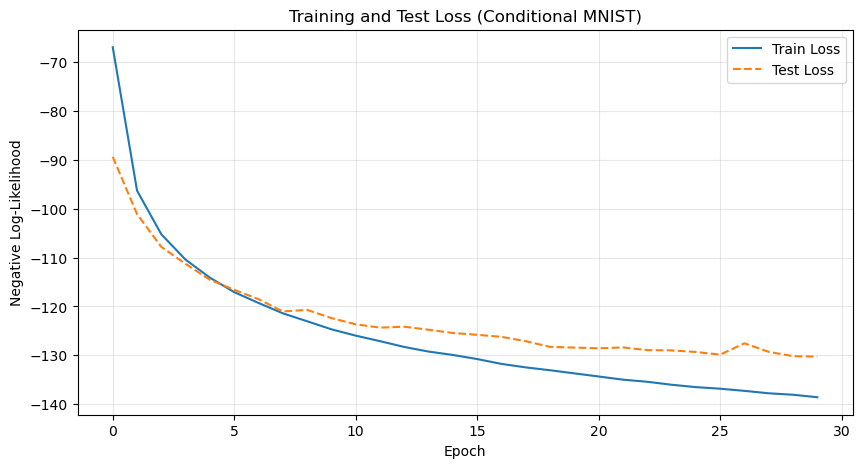

Generating samples from Conditional MNIST model...


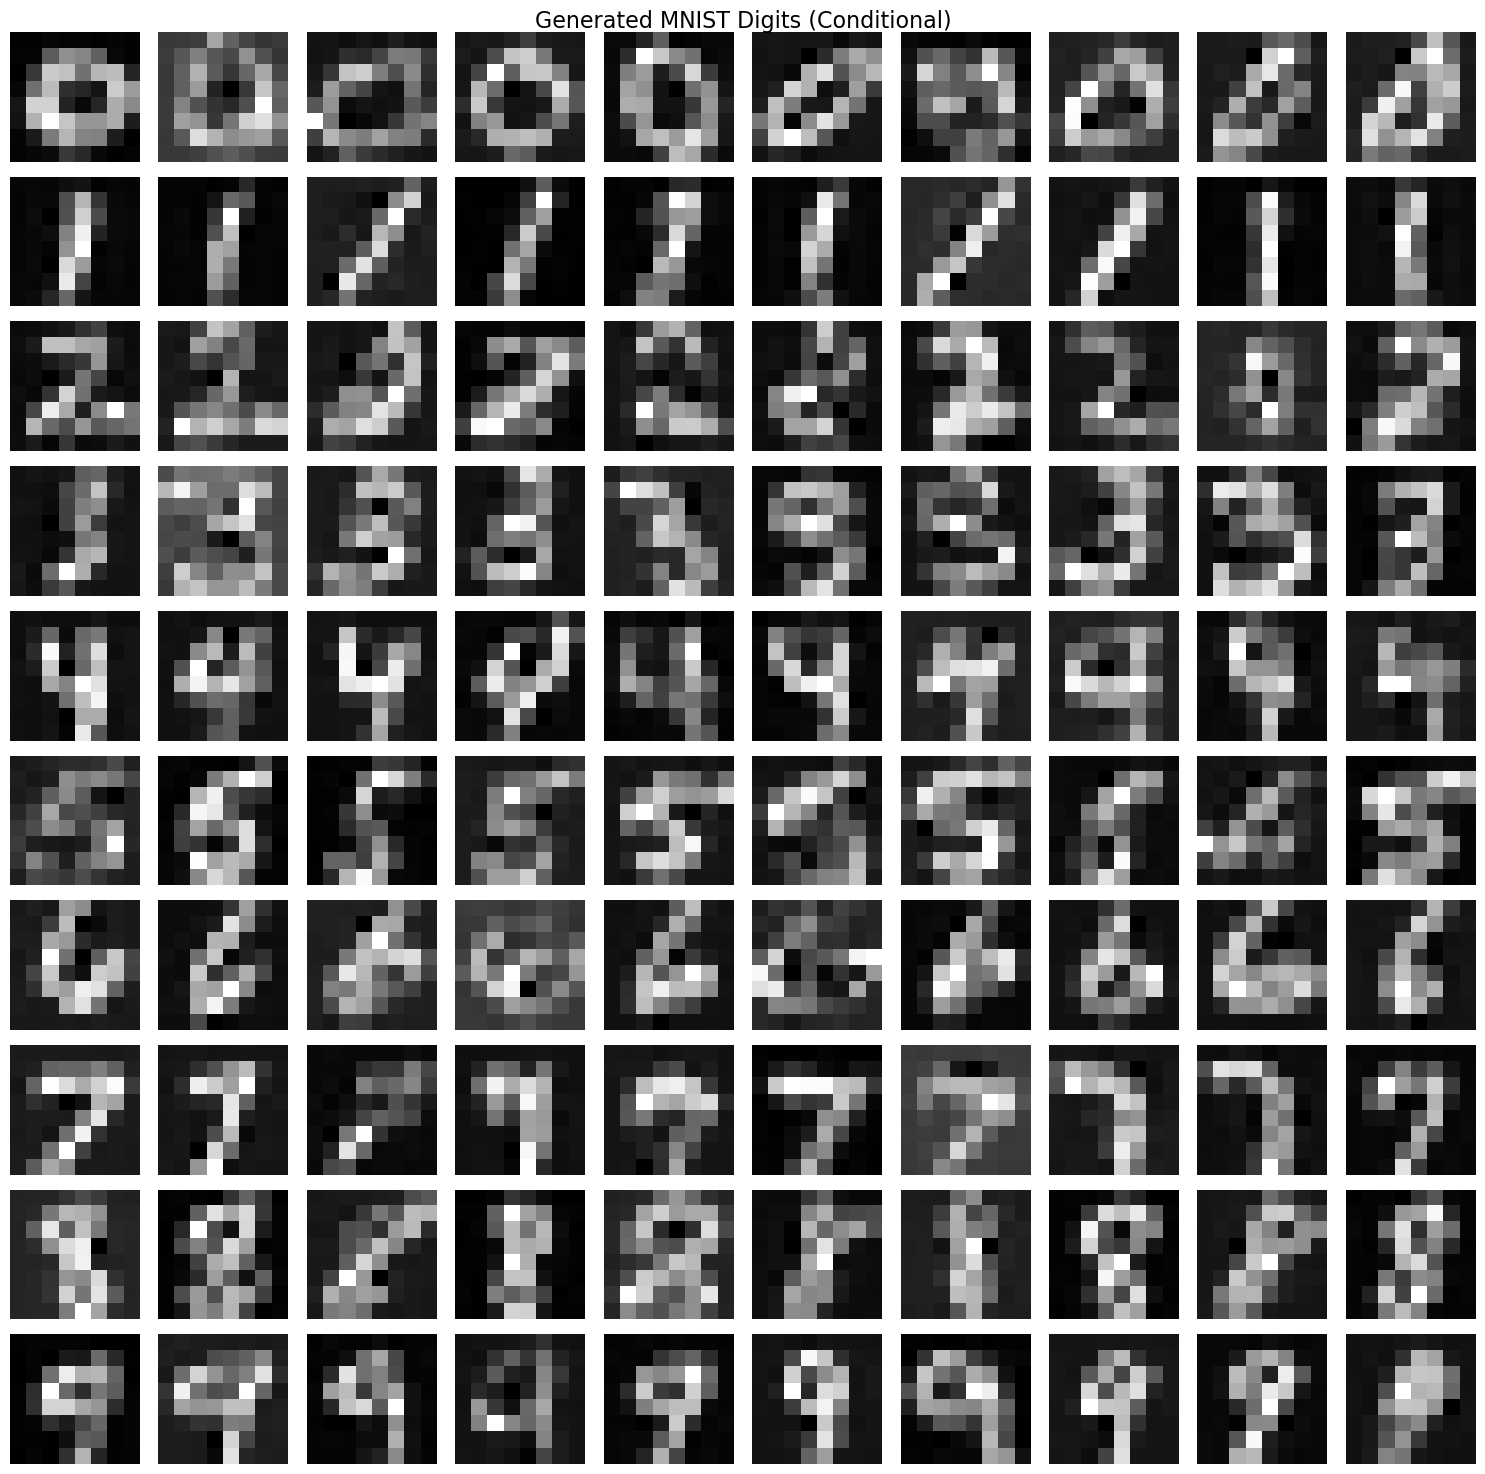

In [ ]:



print("\n=== Conditional MNIST ===")
print("Training conditional RealNVP on full MNIST...")


# Prepare one-hot labels
y_mnist_train_onehot = one_hot_encode(y_mnist_train, num_classes=10)
y_mnist_test_onehot = one_hot_encode(y_mnist_test, num_classes=10)

#Train
model_cond_mnist = RealNVP(input_size=64, hidden_size=256, blocks=10, condition_size=10)
losses_cond_mnist_train, losses_cond_mnist_test = train_inn(
    model_cond_mnist, 
    X_mnist_train, 
    X_test=X_mnist_test,                
    epochs=30, 
    batch_size=128, 
    lr=0.001, 
    condition=y_mnist_train_onehot,
    condition_test=y_mnist_test_onehot 
)


print("\n=== Conditional MNIST (Task 4.3) ===")
print("Training conditional RealNVP on full MNIST...")





plt.figure(figsize=(10, 5))
plt.plot(losses_cond_mnist_train, label='Train Loss')
plt.plot(losses_cond_mnist_test, label='Test Loss', linestyle='--') 
plt.title('Training and Test Loss (Conditional MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend() 
plt.grid(True, alpha=0.3)
plt.show()


print("Generating samples from Conditional MNIST model...")
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

model_cond_mnist.eval()

model_cond_mnist.eval()

for digit in range(10):

    cond = np.zeros((1, 10))
    cond[0, digit] = 1
    
    with torch.no_grad():
        X_gen = model_cond_mnist.sample(10, conditions=cond)
    
    for i in range(10):

        axes[digit, i].imshow(X_gen[i].reshape(8, 8), cmap='gray')
        axes[digit, i].axis('off')
    
    axes[digit, 0].set_ylabel(f'Digit {digit}', fontsize=12)

plt.suptitle('Generated MNIST Digits (Conditional)', fontsize=16)
plt.tight_layout()
plt.show()



=== Evaluation: Classifier Consistency on Synthetic MNIST ===
Training auxiliary classifier on real MNIST data...
Generating synthetic dataset for evaluation (200 samples per digit)...
Classifier Accuracy on Synthetic MNIST: 95.50%
Average Confidence: 0.7232


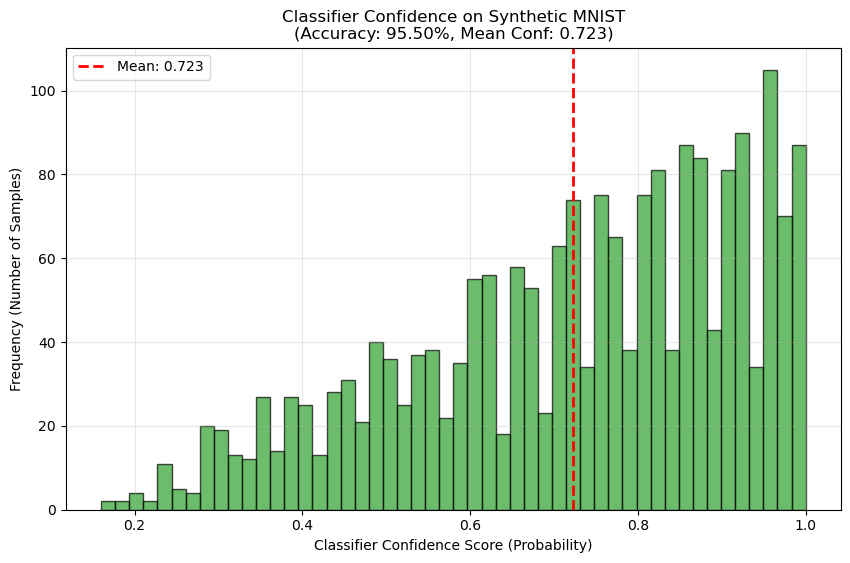


Interpretation:
- High Accuracy means the generated digits are recognizable.
- High Confidence (skewed to the right) means the digits are clear and unambiguous.


---

# Summary and Conclusions

